In [1]:
import numpy as np
import torch

# initialize the RNG deterministically
np.random.seed(42)
torch.manual_seed(42)
torch.set_float32_matmul_precision('medium')

In [2]:
# parameters
dataset_name = ""
model_name = "resnet_ce_mse"
ood = ""

In [3]:
# Parameters
dataset_name = "QPM_species"
ood = "1:4"


In [4]:
# initialize data attributes and loaders
from config import load_config

config = load_config(
    dataset_name = dataset_name,
    model_name = model_name,
    ood = ood,
)
config.load_data()
config.print_labels()
dm = config.datamodule

assert dm

In [5]:
dm.setup("fit")
dm.setup("test")
dm.setup("predict")

Dataset type train label type: species


Loaded 333290 images
Dataset type val label type: species


Loaded 43293 images
Dataset type test label type: species


Loaded 43520 images
Dataset type test label type: species


Loaded 5270 images


In [6]:
# model ids
import pandas as pd
ood_str = ":".join(map(str, config.ood))
df = pd.read_csv("ids.csv").fillna("")
model_id = df[(df.dataset_name == dataset_name) & (df.model_name == model_name) & (df.ood == ood)].id.item()
print(ood_str, model_id)

1:4 77xb9byl


In [7]:
model = config.get_model()

In [8]:
from pathlib import Path
from lightning.pytorch.loggers.wandb import WandbLogger

artifact_dir = WandbLogger.download_artifact(artifact=f"yasith/robustml/model-{model_id}:best")
model = model.__class__.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", config=config)
model = model.cuda()
model.eval();

wandb: Downloading large artifact model-77xb9byl:best, 58.49MB. 1 files... 


wandb:   1 of 1 files downloaded.  


Done. 0:0:0.2


In [9]:
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()
if ood_str:
    predict_loader = dm.predict_dataloader()

In [10]:
from tqdm import tqdm

with torch.no_grad():
    trn_inp = []
    trn_rcn = []
    trn_emb = []
    trn_lgt = []
    trn_tgt = []

    val_inp = []
    val_rcn = []
    val_emb = []
    val_lgt = []
    val_tgt = []

    ind_inp = []
    ind_rcn = []
    ind_emb = []
    ind_lgt = []
    ind_tgt = []

    if ood_str:
        ood_inp = []
        ood_rcn = []
        ood_emb = []
        ood_lgt = []
        ood_tgt = []

    rnd_inp = []
    rnd_rcn = []
    rnd_emb = []
    rnd_lgt = []

    # train set (ind)
    for batch_idx, batch in enumerate(tqdm(train_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        trn_inp.extend(x.detach().cpu().numpy())
        trn_rcn.extend(rcn.detach().cpu().numpy())
        trn_emb.extend(emb.detach().cpu().numpy())
        trn_lgt.extend(lgt.detach().cpu().numpy())
        trn_tgt.extend(y.detach().cpu().numpy())
    print("train - OK")

    # val set (ind)
    for batch_idx, batch in enumerate(tqdm(val_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        val_inp.extend(x.detach().cpu().numpy())
        val_rcn.extend(rcn.detach().cpu().numpy())
        val_emb.extend(emb.detach().cpu().numpy())
        val_lgt.extend(lgt.detach().cpu().numpy())
        val_tgt.extend(y.detach().cpu().numpy())
    print("val - OK")

    # test set (ind)
    for batch_idx, batch in enumerate(tqdm(test_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        ind_inp.extend(x.detach().cpu().numpy())
        ind_rcn.extend(rcn.detach().cpu().numpy())
        ind_emb.extend(emb.detach().cpu().numpy())
        ind_lgt.extend(lgt.detach().cpu().numpy())
        ind_tgt.extend(y.detach().cpu().numpy())
    print("test InD - OK")

    # predict set (ood)
    if ood_str:
        for batch_idx, batch in enumerate(tqdm(predict_loader)):
            x, y, *_ = batch
            x = x.float().cuda()
            emb, lgt, rcn = model(x)
            ood_inp.extend(x.detach().cpu().numpy())
            ood_rcn.extend(rcn.detach().cpu().numpy())
            ood_emb.extend(emb.detach().cpu().numpy())
            ood_lgt.extend(lgt.detach().cpu().numpy())
            ood_tgt.extend(y.detach().cpu().numpy())
        print("test OoD - OK")

    # random set
    rnd_set = torch.randn(100, config.batch_size, *config.input_shape)
    for batch_idx, batch in enumerate(tqdm(rnd_set)):
        x = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        rnd_inp.extend(x.detach().cpu().numpy())
        rnd_rcn.extend(rcn.detach().cpu().numpy())
        rnd_emb.extend(emb.detach().cpu().numpy())
        rnd_lgt.extend(lgt.detach().cpu().numpy())
    print("test RnD - OK")

  0%|                                                                             | 0/5208 [00:00<?, ?it/s]

  0%|                                                                     | 1/5208 [00:00<49:10,  1.76it/s]

  0%|                                                                     | 6/5208 [00:00<07:42, 11.26it/s]

  0%|▏                                                                   | 12/5208 [00:00<03:58, 21.80it/s]

  0%|▏                                                                   | 19/5208 [00:00<02:36, 33.18it/s]

  0%|▎                                                                   | 25/5208 [00:01<02:20, 36.79it/s]

  1%|▍                                                                   | 30/5208 [00:01<02:12, 39.04it/s]

  1%|▍                                                                   | 35/5208 [00:01<02:07, 40.57it/s]

  1%|▌                                                                   | 40/5208 [00:01<02:03, 41.89it/s]

  1%|▌                                                                   | 45/5208 [00:01<02:01, 42.66it/s]

  1%|▋                                                                   | 50/5208 [00:01<01:58, 43.42it/s]

  1%|▋                                                                   | 55/5208 [00:01<01:57, 43.75it/s]

  1%|▊                                                                   | 60/5208 [00:01<01:56, 44.19it/s]

  1%|▊                                                                   | 65/5208 [00:01<01:56, 44.27it/s]

  1%|▉                                                                   | 70/5208 [00:02<01:55, 44.55it/s]

  1%|▉                                                                   | 75/5208 [00:02<01:55, 44.54it/s]

  2%|█                                                                   | 80/5208 [00:02<01:54, 44.75it/s]

  2%|█                                                                   | 85/5208 [00:02<01:54, 44.68it/s]

  2%|█▏                                                                  | 90/5208 [00:02<01:54, 44.86it/s]

  2%|█▏                                                                  | 95/5208 [00:02<01:54, 44.76it/s]

  2%|█▎                                                                 | 100/5208 [00:02<01:53, 44.89it/s]

  2%|█▎                                                                 | 105/5208 [00:02<01:53, 44.78it/s]

  2%|█▍                                                                 | 110/5208 [00:02<01:52, 45.40it/s]

  2%|█▍                                                                 | 115/5208 [00:03<01:52, 45.18it/s]

  2%|█▌                                                                 | 120/5208 [00:03<01:53, 44.98it/s]

  2%|█▌                                                                 | 125/5208 [00:03<01:52, 45.06it/s]

  2%|█▋                                                                 | 130/5208 [00:03<01:53, 44.90it/s]

  3%|█▋                                                                 | 135/5208 [00:03<01:52, 45.01it/s]

  3%|█▊                                                                 | 140/5208 [00:03<01:52, 44.87it/s]

  3%|█▊                                                                 | 145/5208 [00:03<01:52, 45.00it/s]

  3%|█▉                                                                 | 150/5208 [00:03<01:52, 44.87it/s]

  3%|█▉                                                                 | 155/5208 [00:03<01:52, 44.98it/s]

  3%|██                                                                 | 160/5208 [00:04<01:52, 44.84it/s]

  3%|██                                                                 | 165/5208 [00:04<01:52, 44.98it/s]

  3%|██▏                                                                | 170/5208 [00:04<01:52, 44.85it/s]

  3%|██▎                                                                | 175/5208 [00:04<01:51, 44.97it/s]

  3%|██▎                                                                | 180/5208 [00:04<01:52, 44.84it/s]

  4%|██▍                                                                | 185/5208 [00:04<01:51, 44.95it/s]

  4%|██▍                                                                | 190/5208 [00:04<01:51, 44.83it/s]

  4%|██▌                                                                | 195/5208 [00:04<01:51, 44.95it/s]

  4%|██▌                                                                | 200/5208 [00:04<01:51, 44.82it/s]

  4%|██▋                                                                | 205/5208 [00:05<01:51, 44.94it/s]

  4%|██▋                                                                | 210/5208 [00:05<01:51, 45.01it/s]

  4%|██▊                                                                | 215/5208 [00:05<01:51, 44.93it/s]

  4%|██▊                                                                | 220/5208 [00:05<01:51, 44.82it/s]

  4%|██▉                                                                | 225/5208 [00:05<01:50, 44.97it/s]

  4%|██▉                                                                | 230/5208 [00:05<01:51, 44.85it/s]

  5%|███                                                                | 235/5208 [00:05<01:50, 44.96it/s]

  5%|███                                                                | 240/5208 [00:05<01:50, 44.85it/s]

  5%|███▏                                                               | 245/5208 [00:05<01:50, 44.97it/s]

  5%|███▏                                                               | 250/5208 [00:06<01:50, 44.84it/s]

  5%|███▎                                                               | 255/5208 [00:06<01:50, 44.98it/s]

  5%|███▎                                                               | 260/5208 [00:06<01:50, 44.84it/s]

  5%|███▍                                                               | 265/5208 [00:06<01:49, 44.95it/s]

  5%|███▍                                                               | 270/5208 [00:06<01:50, 44.83it/s]

  5%|███▌                                                               | 275/5208 [00:06<01:49, 44.95it/s]

  5%|███▌                                                               | 280/5208 [00:06<01:49, 44.82it/s]

  5%|███▋                                                               | 285/5208 [00:06<01:49, 44.95it/s]

  6%|███▋                                                               | 290/5208 [00:06<01:49, 44.84it/s]

  6%|███▊                                                               | 296/5208 [00:07<01:43, 47.60it/s]

  6%|███▉                                                               | 305/5208 [00:07<01:25, 57.68it/s]

  6%|████                                                               | 311/5208 [00:07<01:26, 56.42it/s]

  6%|████                                                               | 317/5208 [00:07<01:33, 52.41it/s]

  6%|████▏                                                              | 323/5208 [00:07<01:37, 50.07it/s]

  6%|████▏                                                              | 329/5208 [00:07<01:40, 48.53it/s]

  6%|████▎                                                              | 334/5208 [00:07<01:42, 47.67it/s]

  7%|████▎                                                              | 339/5208 [00:07<01:43, 47.02it/s]

  7%|████▍                                                              | 344/5208 [00:07<01:44, 46.36it/s]

  7%|████▍                                                              | 349/5208 [00:08<01:46, 45.81it/s]

  7%|████▌                                                              | 354/5208 [00:08<01:46, 45.65it/s]

  7%|████▌                                                              | 359/5208 [00:08<01:47, 45.31it/s]

  7%|████▋                                                              | 364/5208 [00:08<01:46, 45.30it/s]

  7%|████▊                                                              | 371/5208 [00:08<01:34, 51.14it/s]

  7%|████▉                                                              | 380/5208 [00:08<01:20, 60.26it/s]

  7%|█████                                                              | 389/5208 [00:08<01:12, 66.69it/s]

  8%|█████                                                              | 398/5208 [00:08<01:07, 71.19it/s]

  8%|█████▏                                                             | 407/5208 [00:08<01:04, 74.33it/s]

  8%|█████▎                                                             | 416/5208 [00:09<01:02, 76.67it/s]

  8%|█████▍                                                             | 425/5208 [00:09<01:01, 78.40it/s]

  8%|█████▌                                                             | 434/5208 [00:09<01:00, 79.38it/s]

  8%|█████▋                                                             | 442/5208 [00:09<01:00, 78.56it/s]

  9%|█████▊                                                             | 450/5208 [00:09<01:03, 75.16it/s]

  9%|█████▉                                                             | 458/5208 [00:09<01:04, 73.09it/s]

  9%|█████▉                                                             | 466/5208 [00:09<01:06, 71.82it/s]

  9%|██████                                                             | 474/5208 [00:09<01:06, 70.85it/s]

  9%|██████▏                                                            | 482/5208 [00:09<01:07, 70.35it/s]

  9%|██████▎                                                            | 490/5208 [00:10<01:07, 69.91it/s]

 10%|██████▍                                                            | 497/5208 [00:10<01:07, 69.76it/s]

 10%|██████▍                                                            | 504/5208 [00:10<01:13, 63.95it/s]

 10%|██████▌                                                            | 511/5208 [00:10<01:23, 56.42it/s]

 10%|██████▋                                                            | 517/5208 [00:10<01:29, 52.36it/s]

 10%|██████▋                                                            | 523/5208 [00:10<01:34, 49.60it/s]

 10%|██████▊                                                            | 529/5208 [00:10<01:38, 47.73it/s]

 10%|██████▊                                                            | 534/5208 [00:11<01:40, 46.54it/s]

 10%|██████▉                                                            | 539/5208 [00:11<01:42, 45.67it/s]

 10%|██████▉                                                            | 544/5208 [00:11<01:43, 45.00it/s]

 11%|███████                                                            | 549/5208 [00:11<01:44, 44.52it/s]

 11%|███████▏                                                           | 554/5208 [00:11<01:45, 44.17it/s]

 11%|███████▏                                                           | 559/5208 [00:11<01:45, 43.92it/s]

 11%|███████▎                                                           | 564/5208 [00:11<01:46, 43.75it/s]

 11%|███████▎                                                           | 569/5208 [00:11<01:46, 43.62it/s]

 11%|███████▍                                                           | 574/5208 [00:11<01:46, 43.52it/s]

 11%|███████▍                                                           | 579/5208 [00:12<01:46, 43.48it/s]

 11%|███████▌                                                           | 584/5208 [00:12<01:46, 43.43it/s]

 11%|███████▌                                                           | 589/5208 [00:12<01:44, 44.27it/s]

 11%|███████▋                                                           | 594/5208 [00:12<01:45, 43.66it/s]

 12%|███████▋                                                           | 599/5208 [00:12<01:45, 43.55it/s]

 12%|███████▊                                                           | 604/5208 [00:12<01:45, 43.48it/s]

 12%|███████▊                                                           | 609/5208 [00:12<01:45, 43.42it/s]

 12%|███████▉                                                           | 614/5208 [00:12<01:45, 43.40it/s]

 12%|███████▉                                                           | 619/5208 [00:12<01:45, 43.37it/s]

 12%|████████                                                           | 624/5208 [00:13<01:45, 43.35it/s]

 12%|████████                                                           | 629/5208 [00:13<01:45, 43.35it/s]

 12%|████████▏                                                          | 634/5208 [00:13<01:45, 43.34it/s]

 12%|████████▏                                                          | 639/5208 [00:13<01:45, 43.34it/s]

 12%|████████▎                                                          | 644/5208 [00:13<01:45, 43.33it/s]

 12%|████████▎                                                          | 649/5208 [00:13<01:45, 43.32it/s]

 13%|████████▍                                                          | 654/5208 [00:13<01:45, 43.32it/s]

 13%|████████▍                                                          | 659/5208 [00:13<01:45, 43.31it/s]

 13%|████████▌                                                          | 664/5208 [00:14<01:44, 43.33it/s]

 13%|████████▌                                                          | 669/5208 [00:14<01:44, 43.32it/s]

 13%|████████▋                                                          | 674/5208 [00:14<01:44, 43.32it/s]

 13%|████████▋                                                          | 679/5208 [00:14<01:44, 43.34it/s]

 13%|████████▊                                                          | 684/5208 [00:14<01:45, 42.70it/s]

 13%|████████▊                                                          | 689/5208 [00:14<01:45, 42.88it/s]

 13%|████████▉                                                          | 696/5208 [00:14<01:31, 49.49it/s]

 14%|█████████                                                          | 704/5208 [00:14<01:20, 56.28it/s]

 14%|█████████▏                                                         | 712/5208 [00:14<01:13, 61.15it/s]

 14%|█████████▎                                                         | 720/5208 [00:15<01:09, 64.45it/s]

 14%|█████████▎                                                         | 728/5208 [00:15<01:07, 66.76it/s]

 14%|█████████▍                                                         | 736/5208 [00:15<01:05, 68.51it/s]

 14%|█████████▌                                                         | 744/5208 [00:15<01:04, 69.70it/s]

 14%|█████████▋                                                         | 752/5208 [00:15<01:03, 70.34it/s]

 15%|█████████▊                                                         | 760/5208 [00:15<01:02, 70.73it/s]

 15%|█████████▉                                                         | 768/5208 [00:15<01:02, 71.04it/s]

 15%|█████████▉                                                         | 776/5208 [00:15<01:02, 71.36it/s]

 15%|██████████                                                         | 784/5208 [00:15<01:01, 71.43it/s]

 15%|██████████▏                                                        | 792/5208 [00:16<01:01, 71.51it/s]

 15%|██████████▎                                                        | 800/5208 [00:16<01:01, 71.71it/s]

 16%|██████████▍                                                        | 808/5208 [00:16<01:01, 71.88it/s]

 16%|██████████▍                                                        | 816/5208 [00:16<01:01, 71.99it/s]

 16%|██████████▌                                                        | 824/5208 [00:16<01:00, 71.90it/s]

 16%|██████████▋                                                        | 832/5208 [00:16<01:00, 71.86it/s]

 16%|██████████▊                                                        | 840/5208 [00:16<01:00, 71.73it/s]

 16%|██████████▉                                                        | 848/5208 [00:16<01:00, 71.74it/s]

 16%|███████████                                                        | 856/5208 [00:16<01:00, 71.64it/s]

 17%|███████████                                                        | 864/5208 [00:17<01:00, 71.64it/s]

 17%|███████████▏                                                       | 872/5208 [00:17<01:00, 71.67it/s]

 17%|███████████▎                                                       | 880/5208 [00:17<01:00, 71.86it/s]

 17%|███████████▍                                                       | 888/5208 [00:17<01:00, 71.78it/s]

 17%|███████████▌                                                       | 896/5208 [00:17<01:00, 71.73it/s]

 17%|███████████▋                                                       | 904/5208 [00:17<01:00, 71.68it/s]

 18%|███████████▋                                                       | 912/5208 [00:17<00:59, 71.70it/s]

 18%|███████████▊                                                       | 920/5208 [00:17<00:59, 71.70it/s]

 18%|███████████▉                                                       | 928/5208 [00:17<00:59, 71.61it/s]

 18%|████████████                                                       | 936/5208 [00:18<00:59, 71.60it/s]

 18%|████████████▏                                                      | 944/5208 [00:18<00:59, 71.58it/s]

 18%|████████████▏                                                      | 952/5208 [00:18<00:59, 71.62it/s]

 18%|████████████▎                                                      | 960/5208 [00:18<00:59, 71.56it/s]

 19%|████████████▍                                                      | 968/5208 [00:18<00:59, 71.57it/s]

 19%|████████████▌                                                      | 976/5208 [00:18<00:59, 71.62it/s]

 19%|████████████▋                                                      | 984/5208 [00:18<00:58, 71.60it/s]

 19%|████████████▊                                                      | 992/5208 [00:18<00:58, 71.61it/s]

 19%|████████████▋                                                     | 1000/5208 [00:18<00:58, 71.65it/s]

 19%|████████████▊                                                     | 1008/5208 [00:19<00:58, 71.66it/s]

 20%|████████████▉                                                     | 1016/5208 [00:19<00:58, 71.68it/s]

 20%|████████████▉                                                     | 1024/5208 [00:19<00:58, 71.67it/s]

 20%|█████████████                                                     | 1032/5208 [00:19<00:58, 71.68it/s]

 20%|█████████████▏                                                    | 1040/5208 [00:19<00:58, 71.60it/s]

 20%|█████████████▎                                                    | 1048/5208 [00:19<00:58, 71.58it/s]

 20%|█████████████▍                                                    | 1056/5208 [00:19<00:57, 71.62it/s]

 20%|█████████████▍                                                    | 1064/5208 [00:19<00:57, 71.64it/s]

 21%|█████████████▌                                                    | 1072/5208 [00:19<00:57, 71.66it/s]

 21%|█████████████▋                                                    | 1080/5208 [00:20<00:57, 71.68it/s]

 21%|█████████████▊                                                    | 1088/5208 [00:20<00:57, 71.68it/s]

 21%|█████████████▉                                                    | 1096/5208 [00:20<00:57, 71.68it/s]

 21%|█████████████▉                                                    | 1104/5208 [00:20<00:57, 71.69it/s]

 21%|██████████████                                                    | 1112/5208 [00:20<00:57, 71.70it/s]

 22%|██████████████▏                                                   | 1120/5208 [00:20<00:57, 71.71it/s]

 22%|██████████████▎                                                   | 1128/5208 [00:20<00:56, 71.71it/s]

 22%|██████████████▍                                                   | 1136/5208 [00:20<00:56, 71.70it/s]

 22%|██████████████▍                                                   | 1144/5208 [00:20<00:56, 72.30it/s]

 22%|██████████████▌                                                   | 1152/5208 [00:21<00:55, 73.28it/s]

 22%|██████████████▋                                                   | 1160/5208 [00:21<00:58, 69.55it/s]

 22%|██████████████▊                                                   | 1168/5208 [00:21<00:57, 70.37it/s]

 23%|██████████████▉                                                   | 1176/5208 [00:21<00:56, 71.08it/s]

 23%|███████████████                                                   | 1184/5208 [00:21<00:56, 71.29it/s]

 23%|███████████████                                                   | 1192/5208 [00:21<00:56, 71.42it/s]

 23%|███████████████▏                                                  | 1200/5208 [00:21<00:56, 71.50it/s]

 23%|███████████████▎                                                  | 1208/5208 [00:21<00:55, 71.55it/s]

 23%|███████████████▍                                                  | 1216/5208 [00:21<00:55, 71.54it/s]

 24%|███████████████▌                                                  | 1224/5208 [00:22<00:55, 71.56it/s]

 24%|███████████████▌                                                  | 1232/5208 [00:22<00:55, 71.54it/s]

 24%|███████████████▋                                                  | 1240/5208 [00:22<00:55, 71.56it/s]

 24%|███████████████▊                                                  | 1248/5208 [00:22<00:55, 71.60it/s]

 24%|███████████████▉                                                  | 1256/5208 [00:22<00:55, 71.63it/s]

 24%|████████████████                                                  | 1264/5208 [00:22<00:55, 71.65it/s]

 24%|████████████████                                                  | 1272/5208 [00:22<00:54, 71.66it/s]

 25%|████████████████▏                                                 | 1280/5208 [00:22<00:54, 71.67it/s]

 25%|████████████████▎                                                 | 1288/5208 [00:22<00:54, 71.67it/s]

 25%|████████████████▍                                                 | 1296/5208 [00:23<00:54, 71.96it/s]

 25%|████████████████▌                                                 | 1304/5208 [00:23<00:54, 72.08it/s]

 25%|████████████████▋                                                 | 1312/5208 [00:23<00:53, 72.27it/s]

 25%|████████████████▋                                                 | 1320/5208 [00:23<00:53, 72.22it/s]

 25%|████████████████▊                                                 | 1328/5208 [00:23<00:53, 72.33it/s]

 26%|████████████████▉                                                 | 1336/5208 [00:23<00:53, 72.40it/s]

 26%|█████████████████                                                 | 1344/5208 [00:23<00:53, 72.44it/s]

 26%|█████████████████▏                                                | 1352/5208 [00:23<00:53, 72.42it/s]

 26%|█████████████████▏                                                | 1360/5208 [00:23<00:53, 72.39it/s]

 26%|█████████████████▎                                                | 1368/5208 [00:24<00:53, 72.32it/s]

 26%|█████████████████▍                                                | 1376/5208 [00:24<00:53, 72.26it/s]

 27%|█████████████████▌                                                | 1384/5208 [00:24<00:52, 72.25it/s]

 27%|█████████████████▋                                                | 1392/5208 [00:24<00:52, 72.20it/s]

 27%|█████████████████▋                                                | 1400/5208 [00:24<00:52, 72.20it/s]

 27%|█████████████████▊                                                | 1408/5208 [00:24<00:52, 72.16it/s]

 27%|█████████████████▉                                                | 1416/5208 [00:24<00:52, 72.14it/s]

 27%|██████████████████                                                | 1424/5208 [00:24<00:52, 72.10it/s]

 27%|██████████████████▏                                               | 1432/5208 [00:24<00:52, 72.04it/s]

 28%|██████████████████▏                                               | 1440/5208 [00:25<00:52, 72.10it/s]

 28%|██████████████████▎                                               | 1448/5208 [00:25<00:52, 72.13it/s]

 28%|██████████████████▍                                               | 1456/5208 [00:25<00:51, 72.35it/s]

 28%|██████████████████▌                                               | 1464/5208 [00:25<00:51, 72.31it/s]

 28%|██████████████████▋                                               | 1472/5208 [00:25<00:51, 72.20it/s]

 28%|██████████████████▊                                               | 1480/5208 [00:25<00:51, 72.09it/s]

 29%|██████████████████▊                                               | 1488/5208 [00:25<00:51, 72.07it/s]

 29%|██████████████████▉                                               | 1496/5208 [00:25<00:51, 72.08it/s]

 29%|███████████████████                                               | 1504/5208 [00:25<00:51, 72.02it/s]

 29%|███████████████████▏                                              | 1512/5208 [00:26<00:51, 72.04it/s]

 29%|███████████████████▎                                              | 1520/5208 [00:26<00:51, 72.06it/s]

 29%|███████████████████▎                                              | 1528/5208 [00:26<00:51, 72.09it/s]

 29%|███████████████████▍                                              | 1536/5208 [00:26<00:50, 72.04it/s]

 30%|███████████████████▌                                              | 1544/5208 [00:26<00:50, 72.06it/s]

 30%|███████████████████▋                                              | 1552/5208 [00:26<00:50, 72.07it/s]

 30%|███████████████████▊                                              | 1560/5208 [00:26<00:50, 71.97it/s]

 30%|███████████████████▊                                              | 1568/5208 [00:26<00:50, 71.85it/s]

 30%|███████████████████▉                                              | 1576/5208 [00:26<00:50, 71.93it/s]

 30%|████████████████████                                              | 1584/5208 [00:27<00:50, 71.93it/s]

 31%|████████████████████▏                                             | 1592/5208 [00:27<00:50, 71.95it/s]

 31%|████████████████████▎                                             | 1600/5208 [00:27<00:50, 71.96it/s]

 31%|████████████████████▍                                             | 1608/5208 [00:27<00:49, 72.00it/s]

 31%|████████████████████▍                                             | 1616/5208 [00:27<00:49, 72.05it/s]

 31%|████████████████████▌                                             | 1625/5208 [00:27<00:47, 74.98it/s]

 31%|████████████████████▋                                             | 1634/5208 [00:27<00:46, 77.26it/s]

 32%|████████████████████▊                                             | 1643/5208 [00:27<00:45, 78.82it/s]

 32%|████████████████████▉                                             | 1652/5208 [00:27<00:44, 79.99it/s]

 32%|█████████████████████                                             | 1661/5208 [00:28<00:43, 80.77it/s]

 32%|█████████████████████▏                                            | 1670/5208 [00:28<00:43, 81.19it/s]

 32%|█████████████████████▎                                            | 1679/5208 [00:28<00:43, 81.64it/s]

 32%|█████████████████████▍                                            | 1688/5208 [00:28<00:42, 81.94it/s]

 33%|█████████████████████▌                                            | 1697/5208 [00:28<00:42, 82.14it/s]

 33%|█████████████████████▌                                            | 1706/5208 [00:28<00:42, 82.36it/s]

 33%|█████████████████████▋                                            | 1715/5208 [00:28<00:42, 82.52it/s]

 33%|█████████████████████▊                                            | 1724/5208 [00:28<00:42, 82.64it/s]

 33%|█████████████████████▉                                            | 1733/5208 [00:28<00:42, 82.73it/s]

 33%|██████████████████████                                            | 1742/5208 [00:29<00:41, 82.78it/s]

 34%|██████████████████████▏                                           | 1751/5208 [00:29<00:41, 82.82it/s]

 34%|██████████████████████▎                                           | 1760/5208 [00:29<00:41, 82.87it/s]

 34%|██████████████████████▍                                           | 1769/5208 [00:29<00:41, 82.90it/s]

 34%|██████████████████████▌                                           | 1778/5208 [00:29<00:41, 82.92it/s]

 34%|██████████████████████▋                                           | 1787/5208 [00:29<00:41, 82.87it/s]

 34%|██████████████████████▊                                           | 1796/5208 [00:29<00:41, 82.87it/s]

 35%|██████████████████████▊                                           | 1805/5208 [00:29<00:41, 82.86it/s]

 35%|██████████████████████▉                                           | 1814/5208 [00:29<00:40, 82.84it/s]

 35%|███████████████████████                                           | 1823/5208 [00:30<00:40, 82.72it/s]

 35%|███████████████████████▏                                          | 1832/5208 [00:30<00:40, 82.63it/s]

 35%|███████████████████████▎                                          | 1841/5208 [00:30<00:40, 82.59it/s]

 36%|███████████████████████▍                                          | 1850/5208 [00:30<00:40, 82.62it/s]

 36%|███████████████████████▌                                          | 1859/5208 [00:30<00:40, 82.56it/s]

 36%|███████████████████████▋                                          | 1868/5208 [00:30<00:40, 82.58it/s]

 36%|███████████████████████▊                                          | 1877/5208 [00:30<00:40, 82.38it/s]

 36%|███████████████████████▉                                          | 1886/5208 [00:30<00:40, 82.92it/s]

 36%|████████████████████████                                          | 1895/5208 [00:30<00:39, 83.37it/s]

 37%|████████████████████████▏                                         | 1904/5208 [00:30<00:39, 83.69it/s]

 37%|████████████████████████▏                                         | 1913/5208 [00:31<00:39, 83.76it/s]

 37%|████████████████████████▎                                         | 1922/5208 [00:31<00:39, 83.84it/s]

 37%|████████████████████████▍                                         | 1931/5208 [00:31<00:39, 83.93it/s]

 37%|████████████████████████▌                                         | 1940/5208 [00:31<00:38, 83.99it/s]

 37%|████████████████████████▋                                         | 1949/5208 [00:31<00:38, 83.93it/s]

 38%|████████████████████████▊                                         | 1958/5208 [00:31<00:38, 83.94it/s]

 38%|████████████████████████▉                                         | 1967/5208 [00:31<00:38, 83.74it/s]

 38%|█████████████████████████                                         | 1976/5208 [00:31<00:38, 83.82it/s]

 38%|█████████████████████████▏                                        | 1985/5208 [00:31<00:38, 83.94it/s]

 38%|█████████████████████████▎                                        | 1994/5208 [00:32<00:38, 83.99it/s]

 38%|█████████████████████████▍                                        | 2003/5208 [00:32<00:38, 84.01it/s]

 39%|█████████████████████████▍                                        | 2012/5208 [00:32<00:38, 83.94it/s]

 39%|█████████████████████████▌                                        | 2021/5208 [00:32<00:37, 83.97it/s]

 39%|█████████████████████████▋                                        | 2030/5208 [00:32<00:37, 84.05it/s]

 39%|█████████████████████████▊                                        | 2039/5208 [00:32<00:37, 83.97it/s]

 39%|█████████████████████████▉                                        | 2048/5208 [00:32<00:37, 83.98it/s]

 39%|██████████████████████████                                        | 2057/5208 [00:32<00:37, 84.00it/s]

 40%|██████████████████████████▏                                       | 2066/5208 [00:32<00:37, 84.00it/s]

 40%|██████████████████████████▎                                       | 2075/5208 [00:33<00:37, 83.93it/s]

 40%|██████████████████████████▍                                       | 2084/5208 [00:33<00:37, 83.94it/s]

 40%|██████████████████████████▌                                       | 2093/5208 [00:33<00:37, 83.93it/s]

 40%|██████████████████████████▋                                       | 2102/5208 [00:33<00:37, 83.89it/s]

 41%|██████████████████████████▊                                       | 2111/5208 [00:33<00:37, 83.48it/s]

 41%|██████████████████████████▊                                       | 2120/5208 [00:33<00:37, 83.10it/s]

 41%|██████████████████████████▉                                       | 2129/5208 [00:33<00:37, 82.91it/s]

 41%|███████████████████████████                                       | 2138/5208 [00:33<00:37, 82.87it/s]

 41%|███████████████████████████▏                                      | 2147/5208 [00:33<00:36, 82.82it/s]

 41%|███████████████████████████▎                                      | 2156/5208 [00:34<00:36, 82.80it/s]

 42%|███████████████████████████▍                                      | 2165/5208 [00:34<00:36, 82.80it/s]

 42%|███████████████████████████▌                                      | 2174/5208 [00:34<00:36, 82.83it/s]

 42%|███████████████████████████▋                                      | 2183/5208 [00:34<00:36, 82.80it/s]

 42%|███████████████████████████▊                                      | 2192/5208 [00:34<00:36, 82.71it/s]

 42%|███████████████████████████▉                                      | 2201/5208 [00:34<00:36, 82.71it/s]

 42%|████████████████████████████                                      | 2210/5208 [00:34<00:36, 82.68it/s]

 43%|████████████████████████████                                      | 2219/5208 [00:34<00:36, 82.60it/s]

 43%|████████████████████████████▏                                     | 2228/5208 [00:34<00:36, 82.56it/s]

 43%|████████████████████████████▎                                     | 2237/5208 [00:34<00:35, 82.57it/s]

 43%|████████████████████████████▍                                     | 2246/5208 [00:35<00:35, 82.61it/s]

 43%|████████████████████████████▌                                     | 2255/5208 [00:35<00:35, 82.58it/s]

 43%|████████████████████████████▋                                     | 2264/5208 [00:35<00:35, 82.56it/s]

 44%|████████████████████████████▊                                     | 2273/5208 [00:35<00:35, 82.56it/s]

 44%|████████████████████████████▉                                     | 2282/5208 [00:35<00:35, 82.54it/s]

 44%|█████████████████████████████                                     | 2291/5208 [00:35<00:35, 82.52it/s]

 44%|█████████████████████████████▏                                    | 2300/5208 [00:35<00:35, 82.48it/s]

 44%|█████████████████████████████▎                                    | 2309/5208 [00:35<00:35, 82.38it/s]

 45%|█████████████████████████████▍                                    | 2318/5208 [00:35<00:35, 82.32it/s]

 45%|█████████████████████████████▍                                    | 2327/5208 [00:36<00:35, 82.26it/s]

 45%|█████████████████████████████▌                                    | 2336/5208 [00:36<00:35, 81.89it/s]

 45%|█████████████████████████████▋                                    | 2345/5208 [00:36<00:34, 81.86it/s]

 45%|█████████████████████████████▊                                    | 2354/5208 [00:36<00:34, 81.98it/s]

 45%|█████████████████████████████▉                                    | 2363/5208 [00:36<00:34, 82.02it/s]

 46%|██████████████████████████████                                    | 2372/5208 [00:36<00:34, 81.99it/s]

 46%|██████████████████████████████▏                                   | 2381/5208 [00:36<00:34, 82.04it/s]

 46%|██████████████████████████████▎                                   | 2390/5208 [00:36<00:34, 82.07it/s]

 46%|██████████████████████████████▍                                   | 2399/5208 [00:36<00:34, 82.10it/s]

 46%|██████████████████████████████▌                                   | 2408/5208 [00:37<00:34, 82.11it/s]

 46%|██████████████████████████████▋                                   | 2417/5208 [00:37<00:33, 82.14it/s]

 47%|██████████████████████████████▋                                   | 2426/5208 [00:37<00:33, 82.17it/s]

 47%|██████████████████████████████▊                                   | 2435/5208 [00:37<00:33, 82.15it/s]

 47%|██████████████████████████████▉                                   | 2444/5208 [00:37<00:33, 82.13it/s]

 47%|███████████████████████████████                                   | 2453/5208 [00:37<00:33, 82.13it/s]

 47%|███████████████████████████████▏                                  | 2462/5208 [00:37<00:33, 82.16it/s]

 47%|███████████████████████████████▎                                  | 2471/5208 [00:37<00:33, 82.12it/s]

 48%|███████████████████████████████▍                                  | 2480/5208 [00:37<00:33, 82.15it/s]

 48%|███████████████████████████████▌                                  | 2489/5208 [00:38<00:33, 82.13it/s]

 48%|███████████████████████████████▋                                  | 2498/5208 [00:38<00:32, 82.16it/s]

 48%|███████████████████████████████▊                                  | 2507/5208 [00:38<00:32, 82.17it/s]

 48%|███████████████████████████████▉                                  | 2516/5208 [00:38<00:32, 82.18it/s]

 48%|███████████████████████████████▉                                  | 2525/5208 [00:38<00:32, 82.17it/s]

 49%|████████████████████████████████                                  | 2534/5208 [00:38<00:32, 82.18it/s]

 49%|████████████████████████████████▏                                 | 2543/5208 [00:38<00:32, 82.18it/s]

 49%|████████████████████████████████▎                                 | 2552/5208 [00:38<00:32, 81.88it/s]

 49%|████████████████████████████████▍                                 | 2561/5208 [00:38<00:32, 81.97it/s]

 49%|████████████████████████████████▌                                 | 2570/5208 [00:39<00:32, 82.05it/s]

 50%|████████████████████████████████▋                                 | 2579/5208 [00:39<00:32, 82.11it/s]

 50%|████████████████████████████████▊                                 | 2588/5208 [00:39<00:31, 82.15it/s]

 50%|████████████████████████████████▉                                 | 2597/5208 [00:39<00:31, 82.12it/s]

 50%|█████████████████████████████████                                 | 2606/5208 [00:39<00:31, 82.15it/s]

 50%|█████████████████████████████████▏                                | 2615/5208 [00:39<00:31, 82.15it/s]

 50%|█████████████████████████████████▎                                | 2624/5208 [00:39<00:31, 82.16it/s]

 51%|█████████████████████████████████▎                                | 2633/5208 [00:39<00:31, 82.16it/s]

 51%|█████████████████████████████████▍                                | 2642/5208 [00:39<00:31, 82.15it/s]

 51%|█████████████████████████████████▌                                | 2651/5208 [00:40<00:31, 82.16it/s]

 51%|█████████████████████████████████▋                                | 2660/5208 [00:40<00:31, 82.16it/s]

 51%|█████████████████████████████████▊                                | 2669/5208 [00:40<00:30, 82.05it/s]

 51%|█████████████████████████████████▉                                | 2678/5208 [00:40<00:30, 82.07it/s]

 52%|██████████████████████████████████                                | 2687/5208 [00:40<00:30, 82.09it/s]

 52%|██████████████████████████████████▏                               | 2696/5208 [00:40<00:30, 82.13it/s]

 52%|██████████████████████████████████▎                               | 2705/5208 [00:40<00:30, 82.12it/s]

 52%|██████████████████████████████████▍                               | 2714/5208 [00:40<00:30, 82.14it/s]

 52%|██████████████████████████████████▌                               | 2723/5208 [00:40<00:30, 82.11it/s]

 52%|██████████████████████████████████▌                               | 2732/5208 [00:41<00:30, 82.12it/s]

 53%|██████████████████████████████████▋                               | 2741/5208 [00:41<00:30, 82.16it/s]

 53%|██████████████████████████████████▊                               | 2750/5208 [00:41<00:29, 82.16it/s]

 53%|██████████████████████████████████▉                               | 2759/5208 [00:41<00:29, 82.16it/s]

 53%|███████████████████████████████████                               | 2768/5208 [00:41<00:29, 82.18it/s]

 53%|███████████████████████████████████▏                              | 2777/5208 [00:41<00:29, 82.00it/s]

 53%|███████████████████████████████████▎                              | 2786/5208 [00:41<00:29, 82.06it/s]

 54%|███████████████████████████████████▍                              | 2795/5208 [00:41<00:29, 82.08it/s]

 54%|███████████████████████████████████▌                              | 2804/5208 [00:41<00:29, 82.25it/s]

 54%|███████████████████████████████████▋                              | 2813/5208 [00:41<00:29, 82.43it/s]

 54%|███████████████████████████████████▊                              | 2822/5208 [00:42<00:28, 82.56it/s]

 54%|███████████████████████████████████▉                              | 2831/5208 [00:42<00:28, 82.61it/s]

 55%|███████████████████████████████████▉                              | 2840/5208 [00:42<00:28, 82.65it/s]

 55%|████████████████████████████████████                              | 2849/5208 [00:42<00:28, 82.68it/s]

 55%|████████████████████████████████████▏                             | 2858/5208 [00:42<00:28, 82.71it/s]

 55%|████████████████████████████████████▎                             | 2867/5208 [00:42<00:28, 82.72it/s]

 55%|████████████████████████████████████▍                             | 2876/5208 [00:42<00:28, 82.76it/s]

 55%|████████████████████████████████████▌                             | 2885/5208 [00:42<00:28, 82.42it/s]

 56%|████████████████████████████████████▋                             | 2894/5208 [00:42<00:28, 82.50it/s]

 56%|████████████████████████████████████▊                             | 2903/5208 [00:43<00:27, 82.58it/s]

 56%|████████████████████████████████████▉                             | 2912/5208 [00:43<00:27, 82.62it/s]

 56%|█████████████████████████████████████                             | 2921/5208 [00:43<00:27, 82.60it/s]

 56%|█████████████████████████████████████▏                            | 2930/5208 [00:43<00:27, 82.56it/s]

 56%|█████████████████████████████████████▏                            | 2939/5208 [00:43<00:27, 82.62it/s]

 57%|█████████████████████████████████████▎                            | 2948/5208 [00:43<00:27, 82.68it/s]

 57%|█████████████████████████████████████▍                            | 2957/5208 [00:43<00:27, 82.67it/s]

 57%|█████████████████████████████████████▌                            | 2966/5208 [00:43<00:27, 82.69it/s]

 57%|█████████████████████████████████████▋                            | 2975/5208 [00:43<00:27, 82.66it/s]

 57%|█████████████████████████████████████▊                            | 2984/5208 [00:44<00:26, 82.69it/s]

 57%|█████████████████████████████████████▉                            | 2993/5208 [00:44<00:26, 82.25it/s]

 58%|██████████████████████████████████████                            | 3002/5208 [00:44<00:26, 82.11it/s]

 58%|██████████████████████████████████████▏                           | 3011/5208 [00:44<00:26, 82.41it/s]

 58%|██████████████████████████████████████▎                           | 3020/5208 [00:44<00:26, 82.44it/s]

 58%|██████████████████████████████████████▍                           | 3029/5208 [00:44<00:26, 82.48it/s]

 58%|██████████████████████████████████████▌                           | 3038/5208 [00:44<00:26, 82.58it/s]

 59%|██████████████████████████████████████▌                           | 3047/5208 [00:44<00:26, 82.60it/s]

 59%|██████████████████████████████████████▋                           | 3056/5208 [00:44<00:26, 82.64it/s]

 59%|██████████████████████████████████████▊                           | 3065/5208 [00:45<00:25, 82.70it/s]

 59%|██████████████████████████████████████▉                           | 3074/5208 [00:45<00:25, 82.73it/s]

 59%|███████████████████████████████████████                           | 3083/5208 [00:45<00:25, 82.70it/s]

 59%|███████████████████████████████████████▏                          | 3092/5208 [00:45<00:25, 82.68it/s]

 60%|███████████████████████████████████████▎                          | 3101/5208 [00:45<00:25, 82.65it/s]

 60%|███████████████████████████████████████▍                          | 3110/5208 [00:45<00:25, 82.32it/s]

 60%|███████████████████████████████████████▌                          | 3119/5208 [00:45<00:25, 82.43it/s]

 60%|███████████████████████████████████████▋                          | 3128/5208 [00:45<00:25, 82.52it/s]

 60%|███████████████████████████████████████▊                          | 3137/5208 [00:45<00:25, 82.60it/s]

 60%|███████████████████████████████████████▊                          | 3146/5208 [00:46<00:24, 82.65it/s]

 61%|███████████████████████████████████████▉                          | 3155/5208 [00:46<00:24, 82.69it/s]

 61%|████████████████████████████████████████                          | 3164/5208 [00:46<00:24, 82.71it/s]

 61%|████████████████████████████████████████▏                         | 3173/5208 [00:46<00:24, 82.75it/s]

 61%|████████████████████████████████████████▎                         | 3182/5208 [00:46<00:24, 82.76it/s]

 61%|████████████████████████████████████████▍                         | 3191/5208 [00:46<00:24, 82.77it/s]

 61%|████████████████████████████████████████▌                         | 3200/5208 [00:46<00:24, 82.78it/s]

 62%|████████████████████████████████████████▋                         | 3209/5208 [00:46<00:24, 82.76it/s]

 62%|████████████████████████████████████████▊                         | 3218/5208 [00:46<00:24, 82.75it/s]

 62%|████████████████████████████████████████▉                         | 3227/5208 [00:47<00:23, 82.70it/s]

 62%|█████████████████████████████████████████                         | 3236/5208 [00:47<00:23, 82.65it/s]

 62%|█████████████████████████████████████████                         | 3245/5208 [00:47<00:23, 82.67it/s]

 62%|█████████████████████████████████████████▏                        | 3254/5208 [00:47<00:23, 82.71it/s]

 63%|█████████████████████████████████████████▎                        | 3263/5208 [00:47<00:23, 82.70it/s]

 63%|█████████████████████████████████████████▍                        | 3272/5208 [00:47<00:23, 82.74it/s]

 63%|█████████████████████████████████████████▌                        | 3281/5208 [00:47<00:23, 82.73it/s]

 63%|█████████████████████████████████████████▋                        | 3290/5208 [00:47<00:23, 82.69it/s]

 63%|█████████████████████████████████████████▊                        | 3299/5208 [00:47<00:23, 82.76it/s]

 64%|█████████████████████████████████████████▉                        | 3308/5208 [00:47<00:22, 82.78it/s]

 64%|██████████████████████████████████████████                        | 3317/5208 [00:48<00:22, 82.76it/s]

 64%|██████████████████████████████████████████▏                       | 3326/5208 [00:48<00:22, 82.73it/s]

 64%|██████████████████████████████████████████▎                       | 3335/5208 [00:48<00:22, 82.76it/s]

 64%|██████████████████████████████████████████▍                       | 3344/5208 [00:48<00:22, 82.75it/s]

 64%|██████████████████████████████████████████▍                       | 3353/5208 [00:48<00:22, 82.76it/s]

 65%|██████████████████████████████████████████▌                       | 3362/5208 [00:48<00:22, 82.81it/s]

 65%|██████████████████████████████████████████▋                       | 3371/5208 [00:48<00:22, 82.84it/s]

 65%|██████████████████████████████████████████▊                       | 3380/5208 [00:48<00:22, 82.53it/s]

 65%|██████████████████████████████████████████▉                       | 3389/5208 [00:48<00:22, 82.67it/s]

 65%|███████████████████████████████████████████                       | 3398/5208 [00:49<00:21, 82.69it/s]

 65%|███████████████████████████████████████████▏                      | 3407/5208 [00:49<00:21, 82.76it/s]

 66%|███████████████████████████████████████████▎                      | 3416/5208 [00:49<00:21, 82.78it/s]

 66%|███████████████████████████████████████████▍                      | 3425/5208 [00:49<00:21, 82.86it/s]

 66%|███████████████████████████████████████████▌                      | 3434/5208 [00:49<00:21, 82.89it/s]

 66%|███████████████████████████████████████████▋                      | 3443/5208 [00:49<00:21, 82.55it/s]

 66%|███████████████████████████████████████████▋                      | 3452/5208 [00:49<00:21, 82.62it/s]

 66%|███████████████████████████████████████████▊                      | 3461/5208 [00:49<00:21, 82.72it/s]

 67%|███████████████████████████████████████████▉                      | 3470/5208 [00:49<00:20, 82.80it/s]

 67%|████████████████████████████████████████████                      | 3479/5208 [00:50<00:20, 82.64it/s]

 67%|████████████████████████████████████████████▏                     | 3488/5208 [00:50<00:20, 82.68it/s]

 67%|████████████████████████████████████████████▎                     | 3497/5208 [00:50<00:20, 82.67it/s]

 67%|████████████████████████████████████████████▍                     | 3506/5208 [00:50<00:20, 82.59it/s]

 67%|████████████████████████████████████████████▌                     | 3515/5208 [00:50<00:20, 82.61it/s]

 68%|████████████████████████████████████████████▋                     | 3524/5208 [00:50<00:20, 82.61it/s]

 68%|████████████████████████████████████████████▊                     | 3533/5208 [00:50<00:20, 82.64it/s]

 68%|████████████████████████████████████████████▉                     | 3542/5208 [00:50<00:20, 82.67it/s]

 68%|█████████████████████████████████████████████                     | 3551/5208 [00:50<00:20, 82.70it/s]

 68%|█████████████████████████████████████████████                     | 3560/5208 [00:51<00:19, 82.68it/s]

 69%|█████████████████████████████████████████████▏                    | 3569/5208 [00:51<00:19, 82.71it/s]

 69%|█████████████████████████████████████████████▎                    | 3578/5208 [00:51<00:19, 82.67it/s]

 69%|█████████████████████████████████████████████▍                    | 3587/5208 [00:51<00:19, 82.69it/s]

 69%|█████████████████████████████████████████████▌                    | 3596/5208 [00:51<00:19, 82.70it/s]

 69%|█████████████████████████████████████████████▋                    | 3605/5208 [00:51<00:19, 82.64it/s]

 69%|█████████████████████████████████████████████▊                    | 3614/5208 [00:51<00:19, 82.68it/s]

 70%|█████████████████████████████████████████████▉                    | 3623/5208 [00:51<00:19, 82.70it/s]

 70%|██████████████████████████████████████████████                    | 3632/5208 [00:51<00:19, 82.67it/s]

 70%|██████████████████████████████████████████████▏                   | 3641/5208 [00:52<00:18, 82.71it/s]

 70%|██████████████████████████████████████████████▎                   | 3650/5208 [00:52<00:18, 82.70it/s]

 70%|██████████████████████████████████████████████▎                   | 3659/5208 [00:52<00:18, 82.75it/s]

 70%|██████████████████████████████████████████████▍                   | 3668/5208 [00:52<00:18, 82.75it/s]

 71%|██████████████████████████████████████████████▌                   | 3677/5208 [00:52<00:18, 82.76it/s]

 71%|██████████████████████████████████████████████▋                   | 3686/5208 [00:52<00:18, 82.76it/s]

 71%|██████████████████████████████████████████████▊                   | 3695/5208 [00:52<00:18, 82.77it/s]

 71%|██████████████████████████████████████████████▉                   | 3704/5208 [00:52<00:18, 82.77it/s]

 71%|███████████████████████████████████████████████                   | 3713/5208 [00:52<00:18, 82.79it/s]

 71%|███████████████████████████████████████████████▏                  | 3722/5208 [00:52<00:17, 82.80it/s]

 72%|███████████████████████████████████████████████▎                  | 3731/5208 [00:53<00:17, 82.77it/s]

 72%|███████████████████████████████████████████████▍                  | 3740/5208 [00:53<00:17, 82.78it/s]

 72%|███████████████████████████████████████████████▌                  | 3749/5208 [00:53<00:17, 82.78it/s]

 72%|███████████████████████████████████████████████▌                  | 3758/5208 [00:53<00:17, 82.77it/s]

 72%|███████████████████████████████████████████████▋                  | 3767/5208 [00:53<00:17, 82.76it/s]

 73%|███████████████████████████████████████████████▊                  | 3776/5208 [00:53<00:17, 82.46it/s]

 73%|███████████████████████████████████████████████▉                  | 3785/5208 [00:53<00:17, 82.54it/s]

 73%|████████████████████████████████████████████████                  | 3794/5208 [00:53<00:17, 82.61it/s]

 73%|████████████████████████████████████████████████▏                 | 3803/5208 [00:53<00:17, 82.37it/s]

 73%|████████████████████████████████████████████████▎                 | 3812/5208 [00:54<00:16, 82.57it/s]

 73%|████████████████████████████████████████████████▍                 | 3821/5208 [00:54<00:16, 82.61it/s]

 74%|████████████████████████████████████████████████▌                 | 3830/5208 [00:54<00:16, 82.64it/s]

 74%|████████████████████████████████████████████████▋                 | 3839/5208 [00:54<00:16, 82.64it/s]

 74%|████████████████████████████████████████████████▊                 | 3848/5208 [00:54<00:16, 82.73it/s]

 74%|████████████████████████████████████████████████▉                 | 3857/5208 [00:54<00:16, 82.72it/s]

 74%|████████████████████████████████████████████████▉                 | 3866/5208 [00:54<00:16, 82.78it/s]

 74%|█████████████████████████████████████████████████                 | 3875/5208 [00:54<00:16, 82.80it/s]

 75%|█████████████████████████████████████████████████▏                | 3884/5208 [00:54<00:15, 82.78it/s]

 75%|█████████████████████████████████████████████████▎                | 3893/5208 [00:55<00:15, 82.77it/s]

 75%|█████████████████████████████████████████████████▍                | 3902/5208 [00:55<00:15, 82.79it/s]

 75%|█████████████████████████████████████████████████▌                | 3911/5208 [00:55<00:15, 82.81it/s]

 75%|█████████████████████████████████████████████████▋                | 3920/5208 [00:55<00:15, 82.84it/s]

 75%|█████████████████████████████████████████████████▊                | 3929/5208 [00:55<00:15, 82.84it/s]

 76%|█████████████████████████████████████████████████▉                | 3938/5208 [00:55<00:15, 82.82it/s]

 76%|██████████████████████████████████████████████████                | 3947/5208 [00:55<00:15, 82.79it/s]

 76%|██████████████████████████████████████████████████▏               | 3956/5208 [00:55<00:15, 82.81it/s]

 76%|██████████████████████████████████████████████████▏               | 3965/5208 [00:55<00:15, 82.82it/s]

 76%|██████████████████████████████████████████████████▎               | 3974/5208 [00:56<00:14, 82.82it/s]

 76%|██████████████████████████████████████████████████▍               | 3983/5208 [00:56<00:14, 82.78it/s]

 77%|██████████████████████████████████████████████████▌               | 3992/5208 [00:56<00:14, 82.78it/s]

 77%|██████████████████████████████████████████████████▋               | 4001/5208 [00:56<00:14, 82.77it/s]

 77%|██████████████████████████████████████████████████▊               | 4010/5208 [00:56<00:14, 82.77it/s]

 77%|██████████████████████████████████████████████████▉               | 4019/5208 [00:56<00:14, 82.78it/s]

 77%|███████████████████████████████████████████████████               | 4028/5208 [00:56<00:14, 82.78it/s]

 78%|███████████████████████████████████████████████████▏              | 4037/5208 [00:56<00:14, 82.78it/s]

 78%|███████████████████████████████████████████████████▎              | 4046/5208 [00:56<00:14, 82.81it/s]

 78%|███████████████████████████████████████████████████▍              | 4055/5208 [00:57<00:13, 82.85it/s]

 78%|███████████████████████████████████████████████████▌              | 4064/5208 [00:57<00:13, 82.85it/s]

 78%|███████████████████████████████████████████████████▌              | 4073/5208 [00:57<00:13, 82.85it/s]

 78%|███████████████████████████████████████████████████▋              | 4082/5208 [00:57<00:13, 82.85it/s]

 79%|███████████████████████████████████████████████████▊              | 4091/5208 [00:57<00:13, 82.88it/s]

 79%|███████████████████████████████████████████████████▉              | 4100/5208 [00:57<00:13, 82.88it/s]

 79%|████████████████████████████████████████████████████              | 4109/5208 [00:57<00:13, 82.79it/s]

 79%|████████████████████████████████████████████████████▏             | 4118/5208 [00:57<00:13, 82.79it/s]

 79%|████████████████████████████████████████████████████▎             | 4127/5208 [00:57<00:13, 82.78it/s]

 79%|████████████████████████████████████████████████████▍             | 4136/5208 [00:57<00:12, 82.79it/s]

 80%|████████████████████████████████████████████████████▌             | 4145/5208 [00:58<00:12, 82.78it/s]

 80%|████████████████████████████████████████████████████▋             | 4154/5208 [00:58<00:12, 82.79it/s]

 80%|████████████████████████████████████████████████████▊             | 4163/5208 [00:58<00:12, 82.78it/s]

 80%|████████████████████████████████████████████████████▊             | 4172/5208 [00:58<00:12, 82.79it/s]

 80%|████████████████████████████████████████████████████▉             | 4181/5208 [00:58<00:12, 82.80it/s]

 80%|█████████████████████████████████████████████████████             | 4190/5208 [00:58<00:12, 82.80it/s]

 81%|█████████████████████████████████████████████████████▏            | 4199/5208 [00:58<00:12, 82.82it/s]

 81%|█████████████████████████████████████████████████████▎            | 4208/5208 [00:58<00:12, 82.81it/s]

 81%|█████████████████████████████████████████████████████▍            | 4217/5208 [00:58<00:11, 82.79it/s]

 81%|█████████████████████████████████████████████████████▌            | 4226/5208 [00:59<00:11, 82.80it/s]

 81%|█████████████████████████████████████████████████████▋            | 4235/5208 [00:59<00:11, 82.79it/s]

 81%|█████████████████████████████████████████████████████▊            | 4244/5208 [00:59<00:11, 82.85it/s]

 82%|█████████████████████████████████████████████████████▉            | 4253/5208 [00:59<00:11, 82.87it/s]

 82%|██████████████████████████████████████████████████████            | 4262/5208 [00:59<00:11, 82.85it/s]

 82%|██████████████████████████████████████████████████████▏           | 4271/5208 [00:59<00:11, 82.84it/s]

 82%|██████████████████████████████████████████████████████▏           | 4280/5208 [00:59<00:11, 82.58it/s]

 82%|██████████████████████████████████████████████████████▎           | 4289/5208 [00:59<00:11, 82.65it/s]

 83%|██████████████████████████████████████████████████████▍           | 4298/5208 [00:59<00:10, 82.73it/s]

 83%|██████████████████████████████████████████████████████▌           | 4307/5208 [01:00<00:10, 82.77it/s]

 83%|██████████████████████████████████████████████████████▋           | 4316/5208 [01:00<00:10, 82.78it/s]

 83%|██████████████████████████████████████████████████████▊           | 4325/5208 [01:00<00:10, 82.77it/s]

 83%|██████████████████████████████████████████████████████▉           | 4334/5208 [01:00<00:10, 82.80it/s]

 83%|███████████████████████████████████████████████████████           | 4343/5208 [01:00<00:10, 82.80it/s]

 84%|███████████████████████████████████████████████████████▏          | 4352/5208 [01:00<00:10, 82.83it/s]

 84%|███████████████████████████████████████████████████████▎          | 4361/5208 [01:00<00:10, 82.79it/s]

 84%|███████████████████████████████████████████████████████▍          | 4370/5208 [01:00<00:10, 82.76it/s]

 84%|███████████████████████████████████████████████████████▍          | 4379/5208 [01:00<00:10, 82.78it/s]

 84%|███████████████████████████████████████████████████████▌          | 4388/5208 [01:01<00:09, 82.79it/s]

 84%|███████████████████████████████████████████████████████▋          | 4397/5208 [01:01<00:09, 82.80it/s]

 85%|███████████████████████████████████████████████████████▊          | 4406/5208 [01:01<00:09, 82.79it/s]

 85%|███████████████████████████████████████████████████████▉          | 4415/5208 [01:01<00:09, 82.80it/s]

 85%|████████████████████████████████████████████████████████          | 4424/5208 [01:01<00:09, 82.81it/s]

 85%|████████████████████████████████████████████████████████▏         | 4433/5208 [01:01<00:09, 82.81it/s]

 85%|████████████████████████████████████████████████████████▎         | 4442/5208 [01:01<00:09, 82.54it/s]

 85%|████████████████████████████████████████████████████████▍         | 4451/5208 [01:01<00:09, 82.61it/s]

 86%|████████████████████████████████████████████████████████▌         | 4460/5208 [01:01<00:09, 82.67it/s]

 86%|████████████████████████████████████████████████████████▋         | 4469/5208 [01:02<00:08, 82.73it/s]

 86%|████████████████████████████████████████████████████████▋         | 4478/5208 [01:02<00:08, 82.76it/s]

 86%|████████████████████████████████████████████████████████▊         | 4487/5208 [01:02<00:08, 82.76it/s]

 86%|████████████████████████████████████████████████████████▉         | 4496/5208 [01:02<00:08, 82.78it/s]

 87%|█████████████████████████████████████████████████████████         | 4505/5208 [01:02<00:08, 82.76it/s]

 87%|█████████████████████████████████████████████████████████▏        | 4514/5208 [01:02<00:08, 82.76it/s]

 87%|█████████████████████████████████████████████████████████▎        | 4523/5208 [01:02<00:08, 82.77it/s]

 87%|█████████████████████████████████████████████████████████▍        | 4532/5208 [01:02<00:08, 82.79it/s]

 87%|█████████████████████████████████████████████████████████▌        | 4541/5208 [01:02<00:08, 82.84it/s]

 87%|█████████████████████████████████████████████████████████▋        | 4550/5208 [01:02<00:07, 82.85it/s]

 88%|█████████████████████████████████████████████████████████▊        | 4559/5208 [01:03<00:07, 82.81it/s]

 88%|█████████████████████████████████████████████████████████▉        | 4568/5208 [01:03<00:07, 82.77it/s]

 88%|██████████████████████████████████████████████████████████        | 4577/5208 [01:03<00:07, 82.77it/s]

 88%|██████████████████████████████████████████████████████████        | 4586/5208 [01:03<00:07, 82.80it/s]

 88%|██████████████████████████████████████████████████████████▏       | 4595/5208 [01:03<00:07, 82.79it/s]

 88%|██████████████████████████████████████████████████████████▎       | 4604/5208 [01:03<00:07, 82.81it/s]

 89%|██████████████████████████████████████████████████████████▍       | 4613/5208 [01:03<00:07, 82.80it/s]

 89%|██████████████████████████████████████████████████████████▌       | 4622/5208 [01:03<00:07, 82.78it/s]

 89%|██████████████████████████████████████████████████████████▋       | 4631/5208 [01:03<00:06, 82.79it/s]

 89%|██████████████████████████████████████████████████████████▊       | 4640/5208 [01:04<00:06, 82.68it/s]

 89%|██████████████████████████████████████████████████████████▉       | 4649/5208 [01:04<00:06, 82.61it/s]

 89%|███████████████████████████████████████████████████████████       | 4658/5208 [01:04<00:06, 82.62it/s]

 90%|███████████████████████████████████████████████████████████▏      | 4667/5208 [01:04<00:06, 82.65it/s]

 90%|███████████████████████████████████████████████████████████▎      | 4676/5208 [01:04<00:06, 82.68it/s]

 90%|███████████████████████████████████████████████████████████▎      | 4685/5208 [01:04<00:06, 82.71it/s]

 90%|███████████████████████████████████████████████████████████▍      | 4694/5208 [01:04<00:06, 82.73it/s]

 90%|███████████████████████████████████████████████████████████▌      | 4703/5208 [01:04<00:06, 82.59it/s]

 90%|███████████████████████████████████████████████████████████▋      | 4712/5208 [01:04<00:06, 82.54it/s]

 91%|███████████████████████████████████████████████████████████▊      | 4721/5208 [01:05<00:05, 82.45it/s]

 91%|███████████████████████████████████████████████████████████▉      | 4730/5208 [01:05<00:05, 82.42it/s]

 91%|████████████████████████████████████████████████████████████      | 4739/5208 [01:05<00:05, 82.31it/s]

 91%|████████████████████████████████████████████████████████████▏     | 4748/5208 [01:05<00:05, 82.33it/s]

 91%|████████████████████████████████████████████████████████████▎     | 4757/5208 [01:05<00:05, 82.31it/s]

 92%|████████████████████████████████████████████████████████████▍     | 4766/5208 [01:05<00:05, 82.31it/s]

 92%|████████████████████████████████████████████████████████████▌     | 4775/5208 [01:05<00:05, 82.28it/s]

 92%|████████████████████████████████████████████████████████████▋     | 4784/5208 [01:05<00:05, 82.27it/s]

 92%|████████████████████████████████████████████████████████████▋     | 4793/5208 [01:05<00:05, 82.24it/s]

 92%|████████████████████████████████████████████████████████████▊     | 4802/5208 [01:06<00:04, 82.23it/s]

 92%|████████████████████████████████████████████████████████████▉     | 4811/5208 [01:06<00:04, 81.96it/s]

 93%|█████████████████████████████████████████████████████████████     | 4820/5208 [01:06<00:04, 82.15it/s]

 93%|█████████████████████████████████████████████████████████████▏    | 4829/5208 [01:06<00:04, 82.16it/s]

 93%|█████████████████████████████████████████████████████████████▎    | 4838/5208 [01:06<00:04, 82.22it/s]

 93%|█████████████████████████████████████████████████████████████▍    | 4847/5208 [01:06<00:04, 82.23it/s]

 93%|█████████████████████████████████████████████████████████████▌    | 4856/5208 [01:06<00:04, 82.25it/s]

 93%|█████████████████████████████████████████████████████████████▋    | 4865/5208 [01:06<00:04, 82.21it/s]

 94%|█████████████████████████████████████████████████████████████▊    | 4874/5208 [01:06<00:04, 82.23it/s]

 94%|█████████████████████████████████████████████████████████████▉    | 4883/5208 [01:07<00:03, 81.95it/s]

 94%|█████████████████████████████████████████████████████████████▉    | 4892/5208 [01:07<00:03, 82.06it/s]

 94%|██████████████████████████████████████████████████████████████    | 4901/5208 [01:07<00:03, 82.10it/s]

 94%|██████████████████████████████████████████████████████████████▏   | 4910/5208 [01:07<00:03, 82.15it/s]

 94%|██████████████████████████████████████████████████████████████▎   | 4919/5208 [01:07<00:03, 82.30it/s]

 95%|██████████████████████████████████████████████████████████████▍   | 4928/5208 [01:07<00:03, 82.44it/s]

 95%|██████████████████████████████████████████████████████████████▌   | 4937/5208 [01:07<00:03, 82.56it/s]

 95%|██████████████████████████████████████████████████████████████▋   | 4946/5208 [01:07<00:03, 82.65it/s]

 95%|██████████████████████████████████████████████████████████████▊   | 4955/5208 [01:07<00:03, 82.69it/s]

 95%|██████████████████████████████████████████████████████████████▉   | 4964/5208 [01:08<00:02, 82.75it/s]

 95%|███████████████████████████████████████████████████████████████   | 4973/5208 [01:08<00:02, 82.78it/s]

 96%|███████████████████████████████████████████████████████████████▏  | 4982/5208 [01:08<00:02, 82.80it/s]

 96%|███████████████████████████████████████████████████████████████▎  | 4991/5208 [01:08<00:02, 82.60it/s]

 96%|███████████████████████████████████████████████████████████████▎  | 5000/5208 [01:08<00:02, 82.65it/s]

 96%|███████████████████████████████████████████████████████████████▍  | 5009/5208 [01:08<00:02, 82.69it/s]

 96%|███████████████████████████████████████████████████████████████▌  | 5018/5208 [01:08<00:02, 82.76it/s]

 97%|███████████████████████████████████████████████████████████████▋  | 5027/5208 [01:08<00:02, 82.79it/s]

 97%|███████████████████████████████████████████████████████████████▊  | 5036/5208 [01:08<00:02, 82.87it/s]

 97%|███████████████████████████████████████████████████████████████▉  | 5045/5208 [01:08<00:01, 82.90it/s]

 97%|████████████████████████████████████████████████████████████████  | 5054/5208 [01:09<00:01, 82.98it/s]

 97%|████████████████████████████████████████████████████████████████▏ | 5063/5208 [01:09<00:01, 82.99it/s]

 97%|████████████████████████████████████████████████████████████████▎ | 5072/5208 [01:09<00:01, 83.01it/s]

 98%|████████████████████████████████████████████████████████████████▍ | 5081/5208 [01:09<00:01, 83.03it/s]

 98%|████████████████████████████████████████████████████████████████▌ | 5090/5208 [01:09<00:01, 83.06it/s]

 98%|████████████████████████████████████████████████████████████████▌ | 5099/5208 [01:09<00:01, 83.06it/s]

 98%|████████████████████████████████████████████████████████████████▋ | 5108/5208 [01:09<00:01, 82.77it/s]

 98%|████████████████████████████████████████████████████████████████▊ | 5117/5208 [01:09<00:01, 82.85it/s]

 98%|████████████████████████████████████████████████████████████████▉ | 5126/5208 [01:09<00:00, 82.90it/s]

 99%|█████████████████████████████████████████████████████████████████ | 5135/5208 [01:10<00:00, 82.93it/s]

 99%|█████████████████████████████████████████████████████████████████▏| 5144/5208 [01:10<00:00, 83.00it/s]

 99%|█████████████████████████████████████████████████████████████████▎| 5153/5208 [01:10<00:00, 83.00it/s]

 99%|█████████████████████████████████████████████████████████████████▍| 5162/5208 [01:10<00:00, 82.97it/s]

 99%|█████████████████████████████████████████████████████████████████▌| 5171/5208 [01:10<00:00, 82.92it/s]

 99%|█████████████████████████████████████████████████████████████████▋| 5180/5208 [01:10<00:00, 82.90it/s]

100%|█████████████████████████████████████████████████████████████████▊| 5189/5208 [01:10<00:00, 82.89it/s]

100%|█████████████████████████████████████████████████████████████████▊| 5198/5208 [01:10<00:00, 82.92it/s]

100%|█████████████████████████████████████████████████████████████████▉| 5207/5208 [01:10<00:00, 80.18it/s]

100%|██████████████████████████████████████████████████████████████████| 5208/5208 [01:11<00:00, 73.33it/s]

train - OK


  0%|                                                                              | 0/677 [00:00<?, ?it/s]

  0%|                                                                      | 1/677 [00:00<05:13,  2.15it/s]

  1%|█                                                                    | 10/677 [00:00<00:29, 22.25it/s]

  3%|█▉                                                                   | 19/677 [00:00<00:17, 38.08it/s]

  4%|██▊                                                                  | 28/677 [00:00<00:12, 50.18it/s]

  5%|███▊                                                                 | 37/677 [00:00<00:10, 59.18it/s]

  7%|████▋                                                                | 46/677 [00:01<00:09, 65.86it/s]

  8%|█████▌                                                               | 55/677 [00:01<00:08, 70.77it/s]

  9%|██████▌                                                              | 64/677 [00:01<00:08, 74.32it/s]

 11%|███████▍                                                             | 73/677 [00:01<00:07, 76.83it/s]

 12%|████████▎                                                            | 82/677 [00:01<00:07, 78.65it/s]

 13%|█████████▎                                                           | 91/677 [00:01<00:07, 79.94it/s]

 15%|██████████                                                          | 100/677 [00:01<00:07, 80.07it/s]

 16%|██████████▉                                                         | 109/677 [00:01<00:07, 80.93it/s]

 17%|███████████▊                                                        | 118/677 [00:01<00:06, 81.53it/s]

 19%|████████████▊                                                       | 127/677 [00:01<00:06, 81.94it/s]

 20%|█████████████▋                                                      | 136/677 [00:02<00:06, 82.22it/s]

 21%|██████████████▌                                                     | 145/677 [00:02<00:06, 82.44it/s]

 23%|███████████████▍                                                    | 154/677 [00:02<00:06, 82.58it/s]

 24%|████████████████▎                                                   | 163/677 [00:02<00:06, 82.71it/s]

 25%|█████████████████▎                                                  | 172/677 [00:02<00:06, 82.77it/s]

 27%|██████████████████▏                                                 | 181/677 [00:02<00:05, 82.79it/s]

 28%|███████████████████                                                 | 190/677 [00:02<00:05, 82.83it/s]

 29%|███████████████████▉                                                | 199/677 [00:02<00:05, 82.80it/s]

 31%|████████████████████▉                                               | 208/677 [00:02<00:05, 82.40it/s]

 32%|█████████████████████▊                                              | 217/677 [00:03<00:05, 82.50it/s]

 33%|██████████████████████▋                                             | 226/677 [00:03<00:05, 82.57it/s]

 35%|███████████████████████▌                                            | 235/677 [00:03<00:05, 82.65it/s]

 36%|████████████████████████▌                                           | 244/677 [00:03<00:05, 82.70it/s]

 37%|█████████████████████████▍                                          | 253/677 [00:03<00:05, 82.77it/s]

 39%|██████████████████████████▎                                         | 262/677 [00:03<00:05, 82.81it/s]

 40%|███████████████████████████▏                                        | 271/677 [00:03<00:04, 82.82it/s]

 41%|████████████████████████████                                        | 280/677 [00:03<00:04, 82.85it/s]

 43%|█████████████████████████████                                       | 289/677 [00:03<00:04, 82.83it/s]

 44%|█████████████████████████████▉                                      | 298/677 [00:04<00:04, 82.83it/s]

 45%|██████████████████████████████▊                                     | 307/677 [00:04<00:04, 82.84it/s]

 47%|███████████████████████████████▋                                    | 316/677 [00:04<00:04, 82.84it/s]

 48%|████████████████████████████████▋                                   | 325/677 [00:04<00:04, 82.84it/s]

 49%|█████████████████████████████████▌                                  | 334/677 [00:04<00:04, 82.89it/s]

 51%|██████████████████████████████████▍                                 | 343/677 [00:04<00:04, 82.91it/s]

 52%|███████████████████████████████████▎                                | 352/677 [00:04<00:03, 82.95it/s]

 53%|████████████████████████████████████▎                               | 361/677 [00:04<00:03, 82.94it/s]

 55%|█████████████████████████████████████▏                              | 370/677 [00:04<00:03, 82.98it/s]

 56%|██████████████████████████████████████                              | 379/677 [00:05<00:03, 82.99it/s]

 57%|██████████████████████████████████████▉                             | 388/677 [00:05<00:03, 83.00it/s]

 59%|███████████████████████████████████████▉                            | 397/677 [00:05<00:03, 83.05it/s]

 60%|████████████████████████████████████████▊                           | 406/677 [00:05<00:03, 83.00it/s]

 61%|█████████████████████████████████████████▋                          | 415/677 [00:05<00:03, 82.98it/s]

 63%|██████████████████████████████████████████▌                         | 424/677 [00:05<00:03, 82.97it/s]

 64%|███████████████████████████████████████████▍                        | 433/677 [00:05<00:02, 83.00it/s]

 65%|████████████████████████████████████████████▍                       | 442/677 [00:05<00:02, 82.99it/s]

 67%|█████████████████████████████████████████████▎                      | 451/677 [00:05<00:02, 82.92it/s]

 68%|██████████████████████████████████████████████▏                     | 460/677 [00:06<00:02, 82.89it/s]

 69%|███████████████████████████████████████████████                     | 469/677 [00:06<00:02, 82.90it/s]

 71%|████████████████████████████████████████████████                    | 478/677 [00:06<00:02, 82.94it/s]

 72%|████████████████████████████████████████████████▉                   | 487/677 [00:06<00:02, 82.98it/s]

 73%|█████████████████████████████████████████████████▊                  | 496/677 [00:06<00:02, 82.97it/s]

 75%|██████████████████████████████████████████████████▋                 | 505/677 [00:06<00:02, 82.99it/s]

 76%|███████████████████████████████████████████████████▋                | 514/677 [00:06<00:01, 82.92it/s]

 77%|████████████████████████████████████████████████████▌               | 523/677 [00:06<00:01, 82.93it/s]

 79%|█████████████████████████████████████████████████████▍              | 532/677 [00:06<00:01, 82.87it/s]

 80%|██████████████████████████████████████████████████████▎             | 541/677 [00:06<00:01, 82.73it/s]

 81%|███████████████████████████████████████████████████████▏            | 550/677 [00:07<00:01, 82.63it/s]

 83%|████████████████████████████████████████████████████████▏           | 559/677 [00:07<00:01, 82.60it/s]

 84%|█████████████████████████████████████████████████████████           | 568/677 [00:07<00:01, 82.60it/s]

 85%|█████████████████████████████████████████████████████████▉          | 577/677 [00:07<00:01, 82.44it/s]

 87%|██████████████████████████████████████████████████████████▊         | 586/677 [00:07<00:01, 82.45it/s]

 88%|███████████████████████████████████████████████████████████▊        | 595/677 [00:07<00:00, 82.39it/s]

 89%|████████████████████████████████████████████████████████████▋       | 604/677 [00:07<00:00, 82.31it/s]

 91%|█████████████████████████████████████████████████████████████▌      | 613/677 [00:07<00:00, 82.30it/s]

 92%|██████████████████████████████████████████████████████████████▍     | 622/677 [00:07<00:00, 82.00it/s]

 93%|███████████████████████████████████████████████████████████████▍    | 631/677 [00:08<00:00, 81.50it/s]

 95%|████████████████████████████████████████████████████████████████▎   | 640/677 [00:08<00:00, 81.72it/s]

 96%|█████████████████████████████████████████████████████████████████▏  | 649/677 [00:08<00:00, 81.67it/s]

 97%|██████████████████████████████████████████████████████████████████  | 658/677 [00:08<00:00, 81.88it/s]

 99%|██████████████████████████████████████████████████████████████████▉ | 667/677 [00:08<00:00, 81.86it/s]

100%|███████████████████████████████████████████████████████████████████▉| 676/677 [00:08<00:00, 81.84it/s]

100%|████████████████████████████████████████████████████████████████████| 677/677 [00:08<00:00, 76.19it/s]

val - OK


  0%|                                                                              | 0/680 [00:00<?, ?it/s]

  0%|                                                                      | 1/680 [00:00<05:34,  2.03it/s]

  1%|█                                                                    | 10/680 [00:00<00:31, 21.35it/s]

  3%|█▉                                                                   | 19/680 [00:00<00:17, 36.99it/s]

  4%|██▊                                                                  | 28/680 [00:00<00:13, 49.17it/s]

  5%|███▊                                                                 | 37/680 [00:00<00:11, 58.37it/s]

  7%|████▋                                                                | 46/680 [00:01<00:09, 65.27it/s]

  8%|█████▌                                                               | 55/680 [00:01<00:08, 70.17it/s]

  9%|██████▍                                                              | 64/680 [00:01<00:08, 73.63it/s]

 11%|███████▍                                                             | 73/680 [00:01<00:07, 76.30it/s]

 12%|████████▎                                                            | 82/680 [00:01<00:07, 78.34it/s]

 13%|█████████▏                                                           | 91/680 [00:01<00:07, 79.73it/s]

 15%|██████████                                                          | 100/680 [00:01<00:07, 80.73it/s]

 16%|██████████▉                                                         | 109/680 [00:01<00:07, 81.40it/s]

 17%|███████████▊                                                        | 118/680 [00:01<00:06, 81.90it/s]

 19%|████████████▋                                                       | 127/680 [00:02<00:06, 82.16it/s]

 20%|█████████████▌                                                      | 136/680 [00:02<00:06, 82.34it/s]

 21%|██████████████▌                                                     | 145/680 [00:02<00:06, 82.47it/s]

 23%|███████████████▍                                                    | 154/680 [00:02<00:06, 82.52it/s]

 24%|████████████████▎                                                   | 163/680 [00:02<00:06, 82.64it/s]

 25%|█████████████████▏                                                  | 172/680 [00:02<00:06, 82.73it/s]

 27%|██████████████████                                                  | 181/680 [00:02<00:06, 82.84it/s]

 28%|███████████████████                                                 | 190/680 [00:02<00:05, 82.90it/s]

 29%|███████████████████▉                                                | 199/680 [00:02<00:05, 82.93it/s]

 31%|████████████████████▊                                               | 208/680 [00:02<00:05, 82.95it/s]

 32%|█████████████████████▋                                              | 217/680 [00:03<00:05, 82.95it/s]

 33%|██████████████████████▌                                             | 226/680 [00:03<00:05, 82.97it/s]

 35%|███████████████████████▌                                            | 235/680 [00:03<00:05, 82.90it/s]

 36%|████████████████████████▍                                           | 244/680 [00:03<00:05, 82.71it/s]

 37%|█████████████████████████▎                                          | 253/680 [00:03<00:05, 82.58it/s]

 39%|██████████████████████████▏                                         | 262/680 [00:03<00:05, 82.45it/s]

 40%|███████████████████████████                                         | 271/680 [00:03<00:04, 82.69it/s]

 41%|████████████████████████████                                        | 280/680 [00:03<00:04, 82.79it/s]

 42%|████████████████████████████▉                                       | 289/680 [00:03<00:04, 82.89it/s]

 44%|█████████████████████████████▊                                      | 298/680 [00:04<00:04, 82.87it/s]

 45%|██████████████████████████████▋                                     | 307/680 [00:04<00:04, 82.92it/s]

 46%|███████████████████████████████▌                                    | 316/680 [00:04<00:04, 82.95it/s]

 48%|████████████████████████████████▌                                   | 325/680 [00:04<00:04, 82.97it/s]

 49%|█████████████████████████████████▍                                  | 334/680 [00:04<00:04, 83.03it/s]

 50%|██████████████████████████████████▎                                 | 343/680 [00:04<00:04, 83.06it/s]

 52%|███████████████████████████████████▏                                | 352/680 [00:04<00:03, 83.08it/s]

 53%|████████████████████████████████████                                | 361/680 [00:04<00:03, 83.10it/s]

 54%|█████████████████████████████████████                               | 370/680 [00:04<00:03, 83.13it/s]

 56%|█████████████████████████████████████▉                              | 379/680 [00:05<00:03, 83.17it/s]

 57%|██████████████████████████████████████▊                             | 388/680 [00:05<00:03, 83.20it/s]

 58%|███████████████████████████████████████▋                            | 397/680 [00:05<00:03, 83.15it/s]

 60%|████████████████████████████████████████▌                           | 406/680 [00:05<00:03, 82.99it/s]

 61%|█████████████████████████████████████████▌                          | 415/680 [00:05<00:03, 82.87it/s]

 62%|██████████████████████████████████████████▍                         | 424/680 [00:05<00:03, 83.04it/s]

 64%|███████████████████████████████████████████▎                        | 433/680 [00:05<00:02, 83.11it/s]

 65%|████████████████████████████████████████████▏                       | 442/680 [00:05<00:02, 83.18it/s]

 66%|█████████████████████████████████████████████                       | 451/680 [00:05<00:02, 83.22it/s]

 68%|██████████████████████████████████████████████                      | 460/680 [00:06<00:02, 83.21it/s]

 69%|██████████████████████████████████████████████▉                     | 469/680 [00:06<00:02, 83.25it/s]

 70%|███████████████████████████████████████████████▊                    | 478/680 [00:06<00:02, 83.26it/s]

 72%|████████████████████████████████████████████████▋                   | 487/680 [00:06<00:02, 83.25it/s]

 73%|█████████████████████████████████████████████████▌                  | 496/680 [00:06<00:02, 83.25it/s]

 74%|██████████████████████████████████████████████████▌                 | 505/680 [00:06<00:02, 83.25it/s]

 76%|███████████████████████████████████████████████████▍                | 514/680 [00:06<00:01, 83.20it/s]

 77%|████████████████████████████████████████████████████▎               | 523/680 [00:06<00:01, 83.23it/s]

 78%|█████████████████████████████████████████████████████▏              | 532/680 [00:06<00:01, 83.20it/s]

 80%|██████████████████████████████████████████████████████              | 541/680 [00:07<00:01, 83.21it/s]

 81%|███████████████████████████████████████████████████████             | 550/680 [00:07<00:01, 83.23it/s]

 82%|███████████████████████████████████████████████████████▉            | 559/680 [00:07<00:01, 83.22it/s]

 84%|████████████████████████████████████████████████████████▊           | 568/680 [00:07<00:01, 83.20it/s]

 85%|█████████████████████████████████████████████████████████▋          | 577/680 [00:07<00:01, 83.16it/s]

 86%|██████████████████████████████████████████████████████████▌         | 586/680 [00:07<00:01, 83.17it/s]

 88%|███████████████████████████████████████████████████████████▌        | 595/680 [00:07<00:01, 83.18it/s]

 89%|████████████████████████████████████████████████████████████▍       | 604/680 [00:07<00:00, 83.24it/s]

 90%|█████████████████████████████████████████████████████████████▎      | 613/680 [00:07<00:00, 83.27it/s]

 91%|██████████████████████████████████████████████████████████████▏     | 622/680 [00:07<00:00, 83.27it/s]

 93%|███████████████████████████████████████████████████████████████     | 631/680 [00:08<00:00, 83.32it/s]

 94%|████████████████████████████████████████████████████████████████    | 640/680 [00:08<00:00, 83.33it/s]

 95%|████████████████████████████████████████████████████████████████▉   | 649/680 [00:08<00:00, 83.29it/s]

 97%|█████████████████████████████████████████████████████████████████▊  | 658/680 [00:08<00:00, 83.33it/s]

 98%|██████████████████████████████████████████████████████████████████▋ | 667/680 [00:08<00:00, 83.34it/s]

 99%|███████████████████████████████████████████████████████████████████▌| 676/680 [00:08<00:00, 83.27it/s]

100%|████████████████████████████████████████████████████████████████████| 680/680 [00:08<00:00, 76.22it/s]

test InD - OK


  0%|                                                                               | 0/83 [00:00<?, ?it/s]

  1%|▊                                                                      | 1/83 [00:00<00:45,  1.80it/s]

 12%|████████▍                                                             | 10/83 [00:00<00:03, 19.42it/s]

 23%|████████████████                                                      | 19/83 [00:00<00:01, 34.44it/s]

 34%|███████████████████████▌                                              | 28/83 [00:00<00:01, 46.68it/s]

 45%|███████████████████████████████▏                                      | 37/83 [00:00<00:00, 56.33it/s]

 55%|██████████████████████████████████████▊                               | 46/83 [00:01<00:00, 63.64it/s]

 66%|██████████████████████████████████████████████▍                       | 55/83 [00:01<00:00, 69.09it/s]

 77%|█████████████████████████████████████████████████████▉                | 64/83 [00:01<00:00, 73.09it/s]

 88%|█████████████████████████████████████████████████████████████▌        | 73/83 [00:01<00:00, 75.99it/s]

 99%|█████████████████████████████████████████████████████████████████████▏| 82/83 [00:01<00:00, 77.97it/s]

100%|██████████████████████████████████████████████████████████████████████| 83/83 [00:01<00:00, 44.74it/s]

test OoD - OK


  0%|                                                                              | 0/100 [00:00<?, ?it/s]

  9%|██████▎                                                               | 9/100 [00:00<00:01, 85.27it/s]

 18%|████████████▍                                                        | 18/100 [00:00<00:00, 85.41it/s]

 27%|██████████████████▋                                                  | 27/100 [00:00<00:00, 85.58it/s]

 36%|████████████████████████▊                                            | 36/100 [00:00<00:00, 85.70it/s]

 45%|███████████████████████████████                                      | 45/100 [00:00<00:00, 85.76it/s]

 54%|█████████████████████████████████████▎                               | 54/100 [00:00<00:00, 85.87it/s]

 63%|███████████████████████████████████████████▍                         | 63/100 [00:00<00:00, 85.93it/s]

 72%|█████████████████████████████████████████████████▋                   | 72/100 [00:00<00:00, 85.97it/s]

 81%|███████████████████████████████████████████████████████▉             | 81/100 [00:00<00:00, 85.97it/s]

 90%|██████████████████████████████████████████████████████████████       | 90/100 [00:01<00:00, 85.99it/s]

 99%|████████████████████████████████████████████████████████████████████▎| 99/100 [00:01<00:00, 85.99it/s]

100%|████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 85.83it/s]

test RnD - OK


In [11]:
trn_inp = np.array(trn_inp)
trn_rcn = np.array(trn_rcn)
trn_emb = np.array(trn_emb).squeeze()
trn_lgt = np.array(trn_lgt).squeeze()
trn_tgt = np.array(trn_tgt)

val_inp = np.array(val_inp)
val_rcn = np.array(val_rcn)
val_emb = np.array(val_emb).squeeze()
val_lgt = np.array(val_lgt).squeeze()
val_tgt = np.array(val_tgt)

ind_inp = np.array(ind_inp)
ind_rcn = np.array(ind_rcn)
ind_emb = np.array(ind_emb).squeeze()
ind_lgt = np.array(ind_lgt).squeeze()
ind_tgt = np.array(ind_tgt)

if ood_str:
    ood_inp = np.array(ood_inp)
    ood_rcn = np.array(ood_rcn)
    ood_emb = np.array(ood_emb).squeeze()
    ood_lgt = np.array(ood_lgt).squeeze()
    ood_tgt = np.array(ood_tgt)

rnd_inp = np.array(rnd_inp)
rnd_rcn = np.array(rnd_rcn)
rnd_emb = np.array(rnd_emb).squeeze()
rnd_lgt = np.array(rnd_lgt).squeeze()

print(trn_inp.shape, trn_rcn.shape, trn_emb.shape, trn_lgt.shape, trn_tgt.shape)
print(val_inp.shape, val_rcn.shape, val_emb.shape, val_lgt.shape, val_tgt.shape)
print(ind_inp.shape, ind_rcn.shape, ind_emb.shape, ind_lgt.shape, ind_tgt.shape)
if ood_str:
    print(ood_inp.shape, ood_rcn.shape, ood_emb.shape, ood_lgt.shape, ood_tgt.shape)
print(rnd_inp.shape, rnd_rcn.shape, rnd_emb.shape, rnd_lgt.shape)

(333290, 1, 64, 64) (333290, 1, 64, 64) (333290, 512) (333290, 3) (333290,)
(43293, 1, 64, 64) (43293, 1, 64, 64) (43293, 512) (43293, 3) (43293,)
(43520, 1, 64, 64) (43520, 1, 64, 64) (43520, 512) (43520, 3) (43520,)
(5270, 1, 64, 64) (5270, 1, 64, 64) (5270, 512) (5270, 3) (5270,)
(6400, 1, 64, 64) (6400, 1, 64, 64) (6400, 512) (6400, 3)


In [12]:
from tsnecuda import TSNE

n = ind_emb.shape[0]
all_emb = ind_emb
all_lgt = ind_lgt
if ood_str:
    all_emb = np.concatenate([all_emb, ood_emb], axis=0)
    all_lgt = np.concatenate([all_lgt, ood_lgt], axis=0)

tsne = TSNE(n_components=2, perplexity=1000, random_seed=42)
all_emb2d = tsne.fit_transform(all_emb)
ind_emb2d = np.array(all_emb2d[:n], order='C').astype(np.float32)
ood_emb2d = np.array(all_emb2d[n:], order='C').astype(np.float32)
print(ind_emb2d.shape, ood_emb2d.shape)

if all_lgt.shape[-1] > 2:
    tsne = TSNE(n_components=2, perplexity=1000, random_seed=42)
    lgt2d = tsne.fit_transform(all_lgt)
else:
    lgt2d = all_lgt
ind_lgt2d = np.array(lgt2d[:n], order='C').astype(np.float32)
ood_lgt2d = np.array(lgt2d[n:], order='C').astype(np.float32)
print(ind_lgt2d.shape, ood_lgt2d.shape)

(43520, 2) (5270, 2)


(43520, 2) (5270, 2)


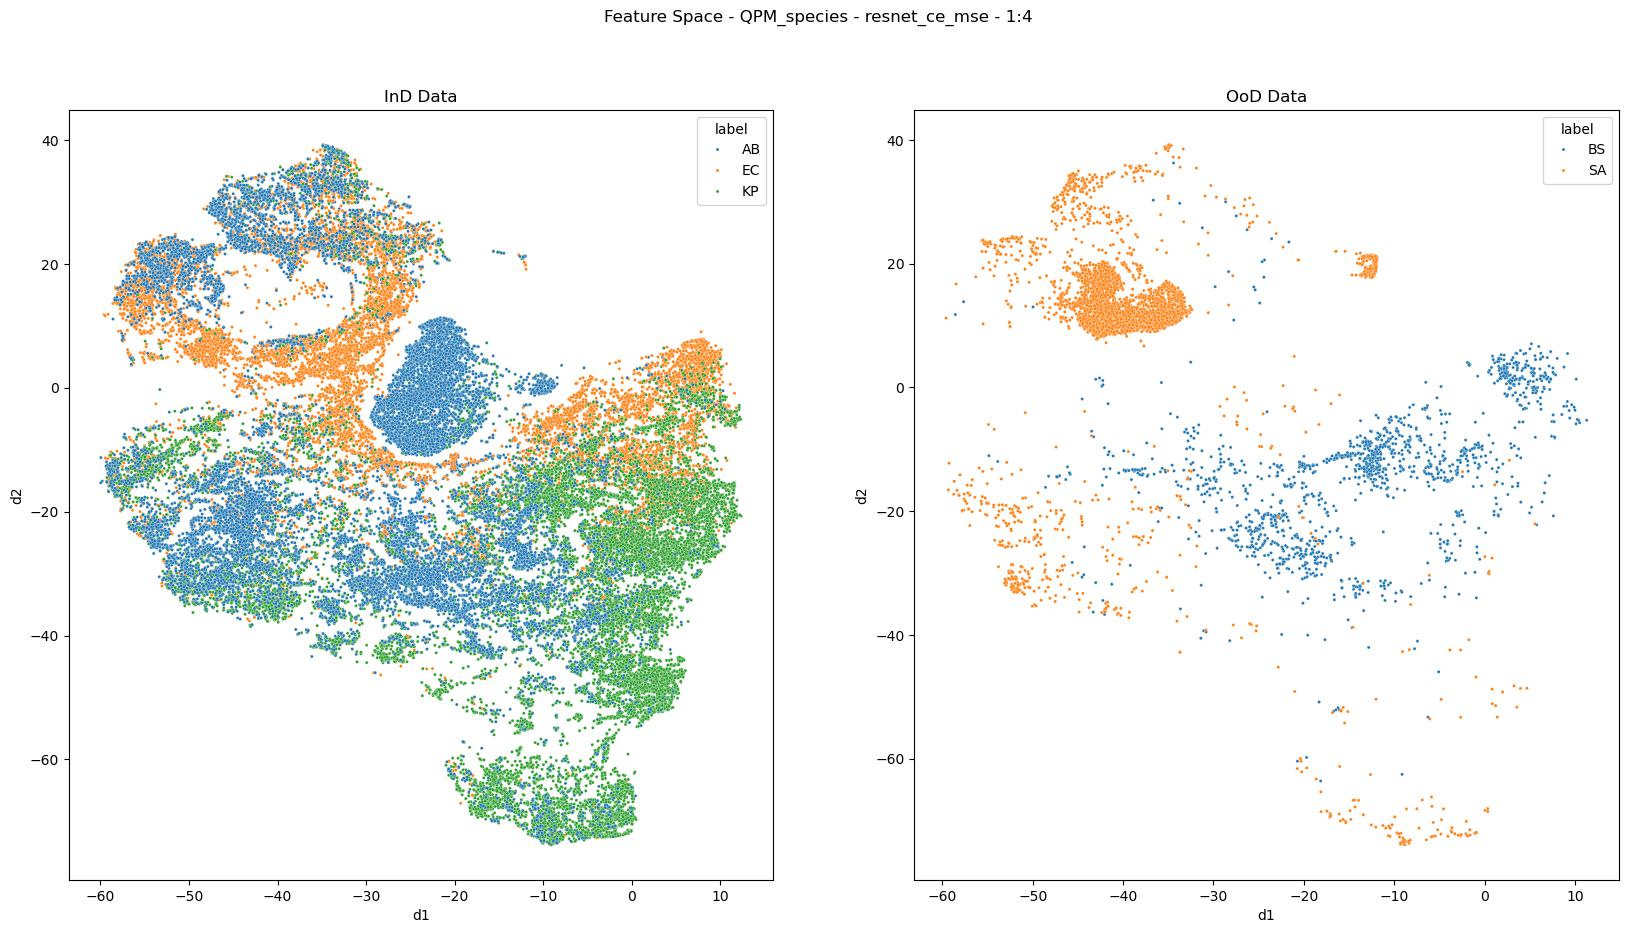

In [13]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

ind_labels = [config.labels[i] for i in ind_tgt]
if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]

df_emb2d = pd.DataFrame()
d1, d2 = ind_emb2d.T
df_emb2d = pd.concat([df_emb2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_emb2d.T
    df_emb2d = pd.concat([df_emb2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Feature Space - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

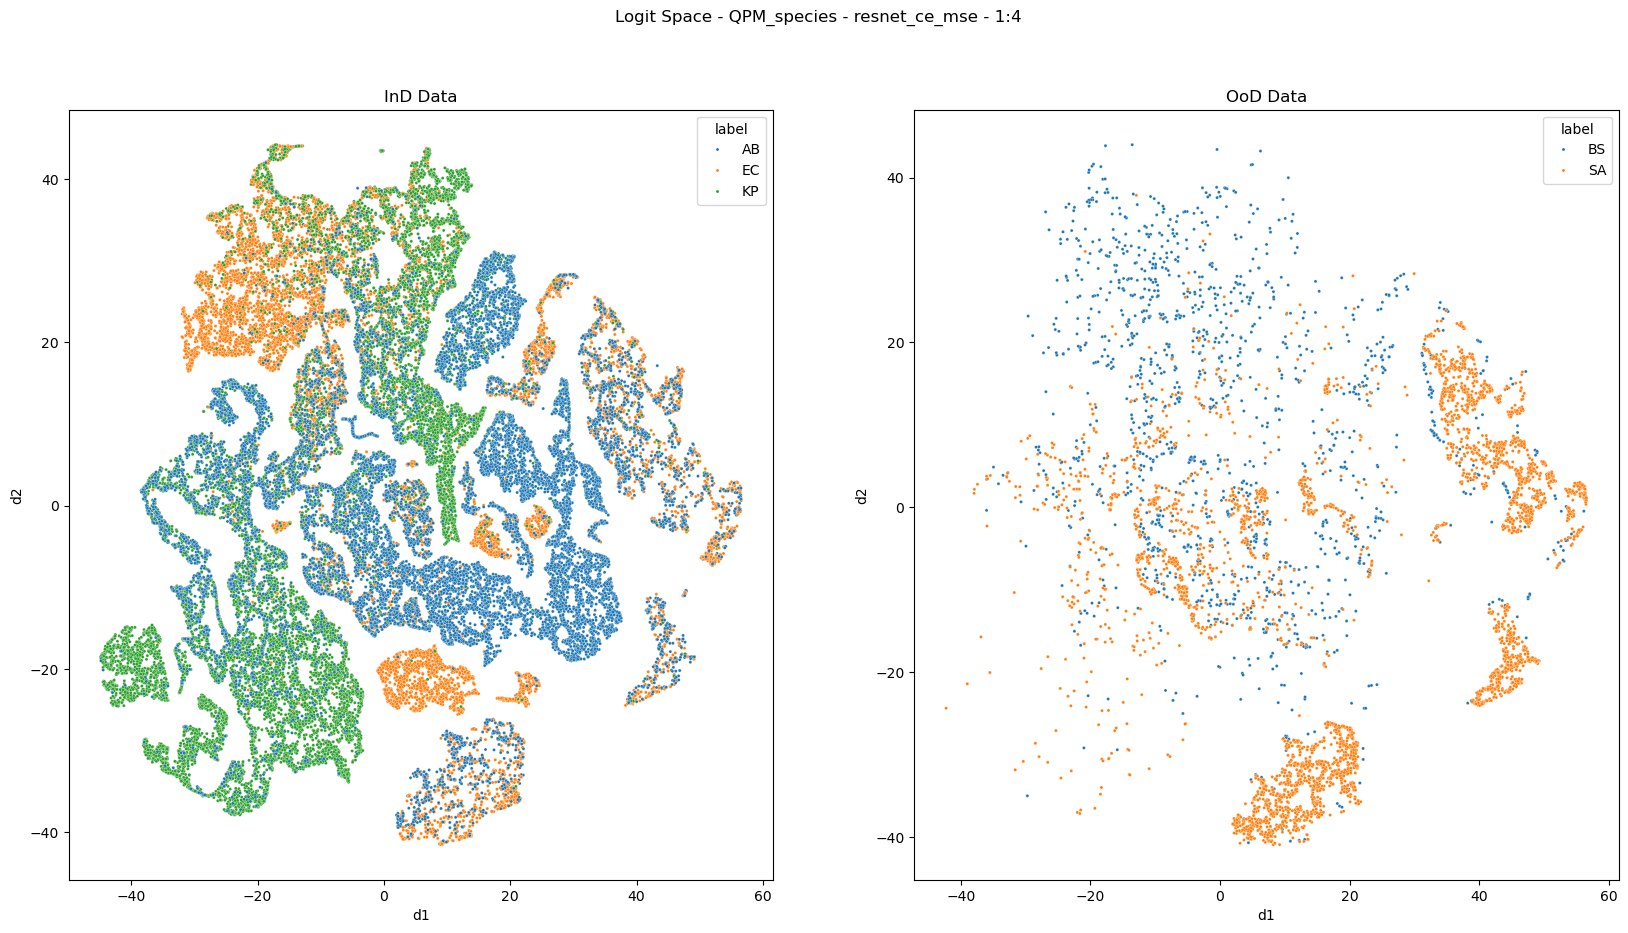

In [14]:
df_lgt2d = pd.DataFrame()
d1, d2 = ind_lgt2d.T
df_lgt2d = pd.concat([df_lgt2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_lgt2d.T
    df_lgt2d = pd.concat([df_lgt2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Logit Space - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_lgt2d[(df_lgt2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_lgt2d[(df_lgt2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

  0%|                                                                                | 0/4 [00:00<?, ?it/s]

 25%|██████████████████                                                      | 1/4 [00:14<00:44, 14.86s/it]

 50%|████████████████████████████████████                                    | 2/4 [00:30<00:30, 15.04s/it]

 75%|██████████████████████████████████████████████████████                  | 3/4 [00:45<00:15, 15.09s/it]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [01:00<00:00, 15.30s/it]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [01:00<00:00, 15.20s/it]

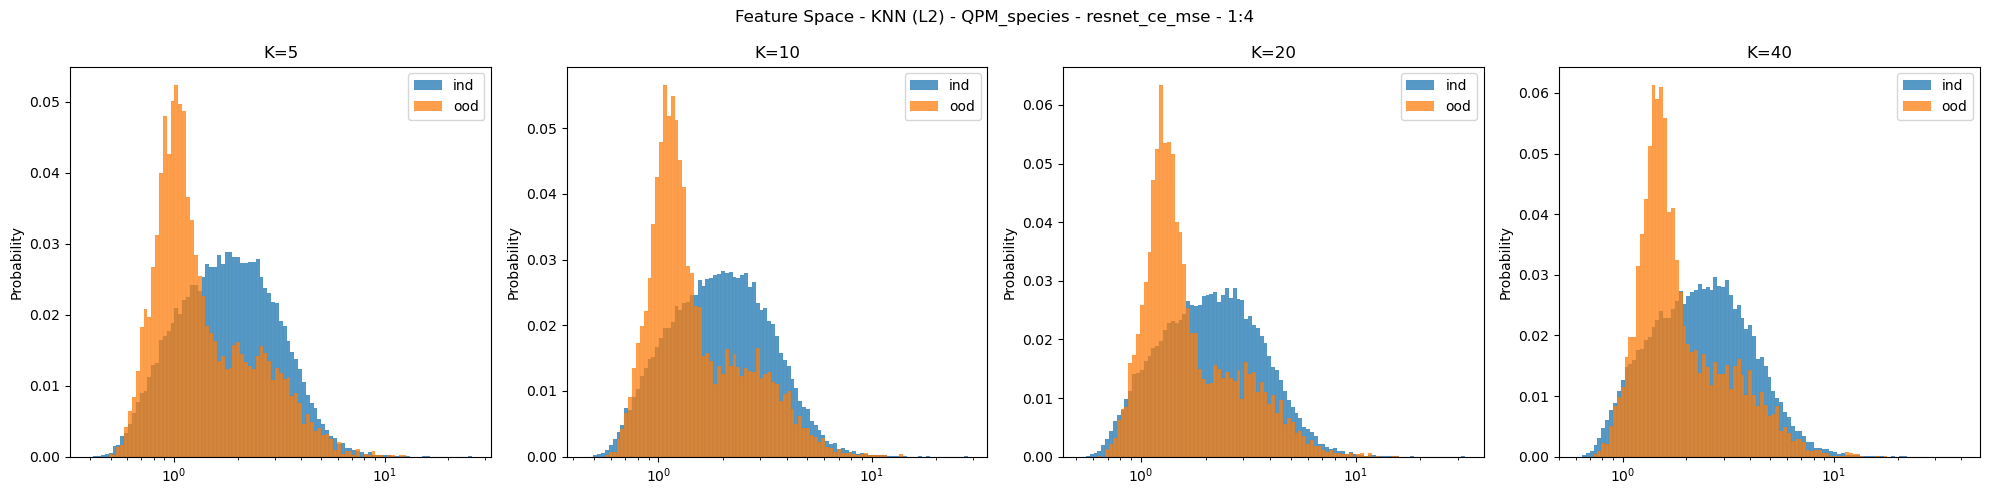

In [15]:
import faiss

index = faiss.IndexFlatL2(ind_emb.shape[-1])
index.add(val_emb)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Feature Space - KNN (L2) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_emb, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_emb, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                | 0/4 [00:00<?, ?it/s]

 25%|██████████████████                                                      | 1/4 [00:14<00:44, 14.67s/it]

 50%|████████████████████████████████████                                    | 2/4 [00:29<00:29, 14.80s/it]

 75%|██████████████████████████████████████████████████████                  | 3/4 [00:44<00:14, 14.83s/it]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:59<00:00, 15.03s/it]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:59<00:00, 14.94s/it]

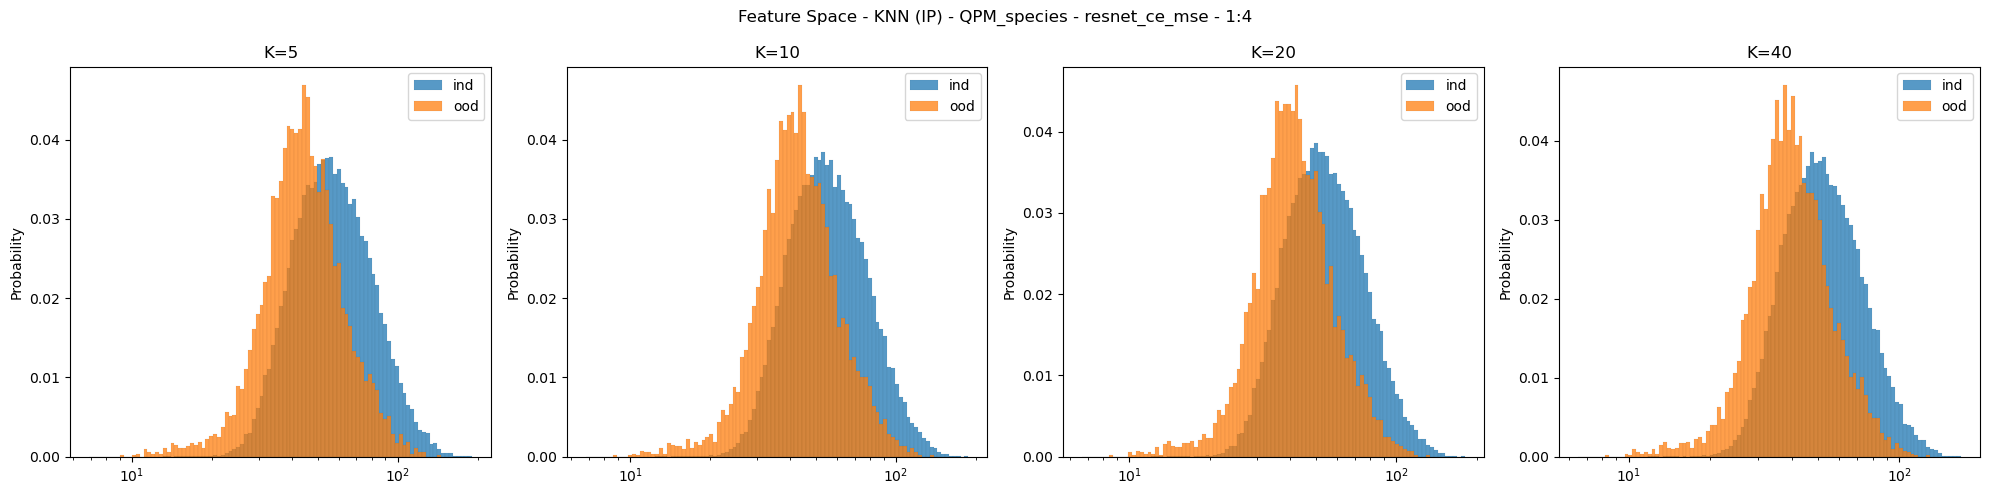

In [16]:
import faiss

index = faiss.IndexFlatIP(ind_emb.shape[-1])
index.add(val_emb)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Feature Space - KNN (IP) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_emb, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_emb, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                | 0/4 [00:00<?, ?it/s]

 25%|██████████████████                                                      | 1/4 [00:02<00:06,  2.10s/it]

 50%|████████████████████████████████████                                    | 2/4 [00:04<00:04,  2.14s/it]

 75%|██████████████████████████████████████████████████████                  | 3/4 [00:06<00:02,  2.22s/it]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:09<00:00,  2.46s/it]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:09<00:00,  2.35s/it]

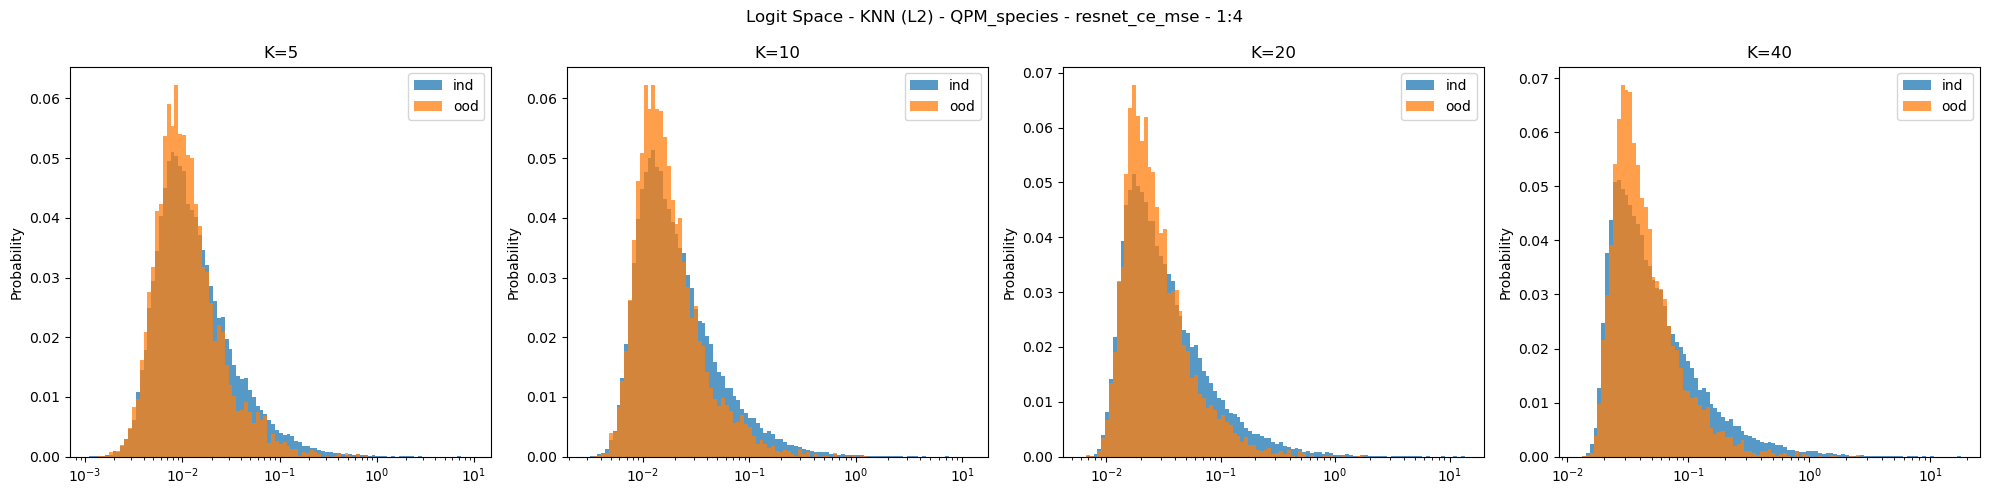

In [17]:
import faiss

index = faiss.IndexFlatL2(ind_lgt.shape[-1])
index.add(val_lgt)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Logit Space - KNN (L2) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_lgt, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_lgt, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                | 0/4 [00:00<?, ?it/s]

 25%|██████████████████                                                      | 1/4 [00:01<00:05,  1.82s/it]

 50%|████████████████████████████████████                                    | 2/4 [00:03<00:03,  1.86s/it]

 75%|██████████████████████████████████████████████████████                  | 3/4 [00:05<00:01,  1.96s/it]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:08<00:00,  2.16s/it]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:08<00:00,  2.07s/it]

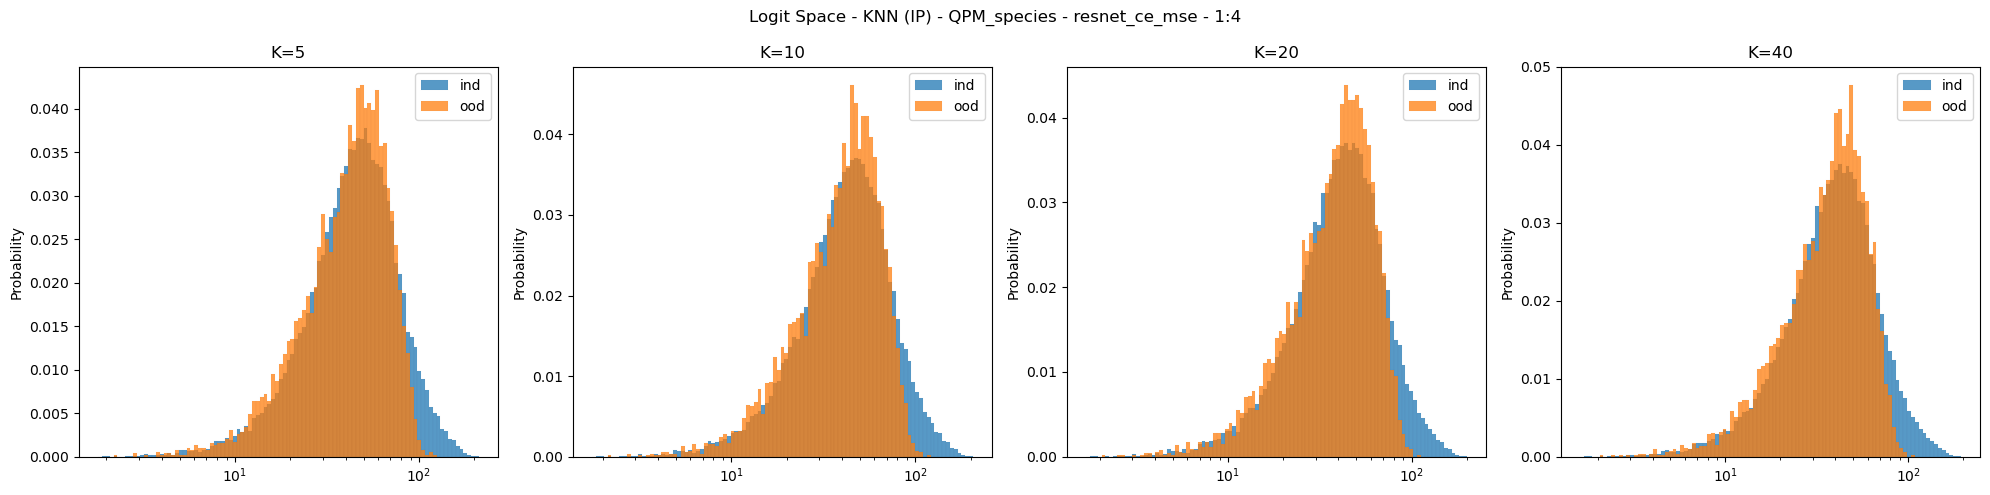

In [18]:
import faiss

index = faiss.IndexFlatIP(ind_lgt.shape[-1])
index.add(val_lgt)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Logit Space - KNN (IP) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_lgt, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_lgt, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

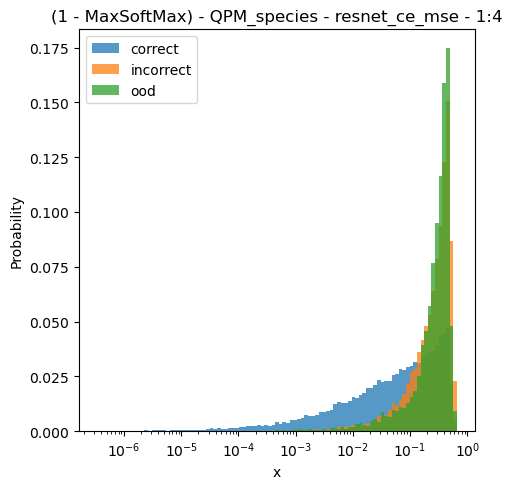

In [19]:
ind_prob = np.exp(ind_lgt) / np.exp(ind_lgt).sum(-1, keepdims=True)
ind_pred = ind_prob.argmax(-1)
ind_ucty = -ind_prob.max(-1) + 1.0

if ood_str:
    ood_prob = np.exp(ood_lgt) / np.exp(ood_lgt).sum(-1, keepdims=True)
    ood_pred = ood_prob.argmax(-1)
    ood_ucty = -ood_prob.max(-1) + 1.0

df_t = pd.DataFrame({"x": ind_ucty[ind_pred == ind_tgt]}).copy()
df_f = pd.DataFrame({"x": ind_ucty[ind_pred != ind_tgt]}).copy()
df = pd.concat([df_t, df_f], ignore_index=True)
if ood_str:
    df_o = pd.DataFrame({"x": ood_ucty}).copy()
    df = pd.concat([df, df_o], ignore_index=True)
df_bins = np.logspace(np.log10(df['x'].min() + 1e-7), np.log10(df['x'].max()), 100)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
sns.histplot(df_t, x="x", label="correct", stat="probability", bins=df_bins, ax=ax)
sns.histplot(df_f, x="x", label="incorrect", stat="probability", bins=df_bins, ax=ax)
if ood_str:
    sns.histplot(df_o, x="x", label="ood", stat="probability", bins=df_bins, ax=ax)
ax.set_xscale("log")
plt.legend()
plt.title(f"(1 - MaxSoftMax) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()

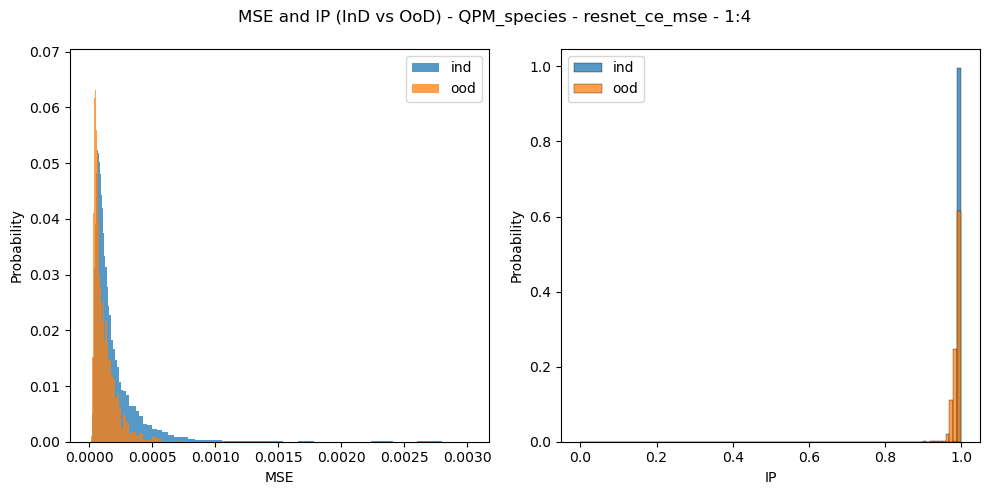

In [20]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

df_rstat = pd.DataFrame()
ni = ind_inp.shape[0]
si = (ni, -1)
_ind_inp = ind_inp.reshape(si)
_ind_rcn = ind_rcn.reshape(si)
_ind_inp_norm = np.linalg.norm(_ind_inp, axis=-1, keepdims=True) + 1e-7
_ind_rcn_norm = np.linalg.norm(_ind_rcn, axis=-1, keepdims=True) + 1e-7
ind_mse = ((_ind_inp - _ind_rcn) ** 2).mean(-1)
ind_ip = ((_ind_inp/_ind_inp_norm) * (_ind_rcn/_ind_rcn_norm)).sum(-1)
df_rstat = pd.concat([df_rstat, pd.DataFrame(dict(target=ind_tgt, mse=ind_mse, ip=ind_ip, source="ind"))], ignore_index=True)

if ood_str:
    no = ood_inp.shape[0]
    so = (no, -1)
    _ood_inp = ood_inp.reshape(so)
    _ood_rcn = ood_rcn.reshape(so)
    _ood_inp_norm = np.linalg.norm(_ood_inp, axis=-1, keepdims=True) + 1e-7
    _ood_rcn_norm = np.linalg.norm(_ood_rcn, axis=-1, keepdims=True) + 1e-7
    ood_mse = ((_ood_inp - _ood_rcn) ** 2).mean(-1)
    ood_ip = ((_ood_inp/_ood_inp_norm) * (_ood_rcn/_ood_rcn_norm)).sum(-1)
    df_rstat = pd.concat([df_rstat, pd.DataFrame(dict(target=ood_tgt, mse=ood_mse, ip=ood_ip, source="ood"))], ignore_index=True)
    
bins_mse = np.logspace(np.log10(df_rstat['mse'].min() + 1e-7), np.log10(df_rstat['mse'].max()), 100)
bins_ip = np.linspace(df_rstat['ip'].min(), df_rstat['ip'].max(), 100)
sns.histplot(df_rstat[df_rstat['source'] == 'ind'], x="mse", label="ind", stat="probability", bins=bins_mse, ax=ax1)
sns.histplot(df_rstat[df_rstat['source'] == 'ind'], x="ip", label="ind", stat="probability", bins=bins_ip, ax=ax2)

if ood_str:
    sns.histplot(df_rstat[df_rstat['source'] == 'ood'], x="mse", label="ood", stat="probability", bins=bins_mse, ax=ax1)
    sns.histplot(df_rstat[df_rstat['source'] == 'ood'], x="ip", label="ood", stat="probability", bins=bins_ip, ax=ax2)

ax1.legend()
ax2.legend()
ax1.set_xlabel("MSE")
ax2.set_xlabel("IP")
plt.suptitle(f"MSE and IP (InD vs OoD) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()